<a href="https://www.kaggle.com/code/kescovar/fork-of-dsn-few-shot-learning-resnet50-analysis?scriptVersionId=278723606" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
from collections import defaultdict
import cv2

print('PyTorch version:', torch.__version__)

PyTorch version: 2.6.0+cu124


In [2]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [3]:
!kaggle kernels output kescovar/fork-of-fork-of-dsn-few-shot-8e0f3d9e8ee -p ~/kaggle/working/

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [4]:
MODEL_PATH_NORMAL = '/kaggle/input/resnet50-26102025/pytorch/default/1/Resnet50_plant_disease_model_26102025.pth'
MODEL_PATH_PLUS = '/kaggle/input/resnet50plus-31102025/pytorch/default/1/Resnet50plus_plant_disease_model_31102025.pth'
MODEL_PATH_FS = '/kaggle/input/resnet50plus-31102025-fromscratch/pytorch/default/1/Resnet50plus_plant_disease_model_31102025_fromsractch.pth'
DATA_DIR = "/kaggle/input/plantvillage-dataset/color"
DATA_DIR_2 = "/kaggle/input/datasetold/Datasetold/Train"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = './gradcam_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

N_SUPPORT = 15
N_QUERY = 10

print('Device:', DEVICE)
print('Model path exists?', os.path.exists(MODEL_PATH_FS))
print('Model path exists?', os.path.exists(MODEL_PATH_NORMAL))
print('Model path exists?', os.path.exists(MODEL_PATH_PLUS))
print('Data dir exists?', os.path.exists(DATA_DIR))

Device: cuda
Model path exists? True
Model path exists? True
Model path exists? True
Data dir exists? True


# Resnet50

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
import pandas as pd
from sklearn.metrics import classification_report


# CONFIGURATION

TRAIN_CSV = '/kaggle/input/classescomplete/train(4).csv'
VAL_CSV = '/kaggle/input/classescomplete/val(2).csv'
TEST_CSV = '/kaggle/input/classescomplete/test(2).csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_SUPPORT = 5  # Few-shot: 5 support samples per class
N_QUERY = 10   # 10 query samples per class
SUBSPACE_DIM = N_SUPPORT - 1

print(f"Device: {DEVICE}")
print(f"Configuration: {N_SUPPORT}-shot, {N_QUERY} queries per class")
print(f"Subspace dimensionality: {SUBSPACE_DIM}")


# STEP 1: Load Class Information

print("\n" + "-"*80)
print("STEP 1: Loading class splits from training...")
print("-"*80)

def get_classes_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return sorted(df['label'].unique())

train_classes = get_classes_from_csv(TRAIN_CSV)
val_classes = get_classes_from_csv(VAL_CSV)
test_classes = get_classes_from_csv(TEST_CSV)

print(f"Training classes: {len(train_classes)}")
print(f"Validation classes: {len(val_classes)}")
print(f"Test classes: {len(test_classes)}")

# Combine all classes for comprehensive evaluation
all_classes = sorted(set(train_classes + val_classes + test_classes))
print(f"\nTotal classes to evaluate: {len(all_classes)}")
print(f"Sample classes: {all_classes[:5]} ...")


# STEP 2: Prepare Dataset for All Classes

print("\n" + "-"*80)
print("STEP 2: Preparing dataset...")
print("-"*80)

data_transforms = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms)

# Build mapping: class name -> new index
class_to_idx = {cls_name: i for i, cls_name in enumerate(all_classes)}

# Filter dataset to only include our target classes
filtered_samples = []
for path, cls_idx in full_dataset.samples:
    cls_name = full_dataset.classes[cls_idx]
    if cls_name in class_to_idx:
        new_idx = class_to_idx[cls_name]
        filtered_samples.append((path, new_idx))

# Update dataset
full_dataset.samples = filtered_samples
full_dataset.targets = [s[1] for s in filtered_samples]
full_dataset.classes = all_classes
full_dataset.class_to_idx = class_to_idx
class_names = all_classes  # For compatibility with reporting code

print(f"Filtered dataset: {len(full_dataset)} images across {len(all_classes)} classes")

# Verify class distribution
class_counts = defaultdict(int)
for _, label in full_dataset.samples:
    class_counts[label] += 1

print(f"\nSample class distribution:")
for cls_idx in sorted(class_counts.keys())[:5]:
    print(f"  {all_classes[cls_idx][:40]:40s}: {class_counts[cls_idx]:4d} samples")
print("  ...")


# STEP 3: Split into Support and Query Sets

print("\n" + "-"*80)
print("STEP 3: Creating support and query split...")
print("-"*80)

def create_support_query_split(dataset, n_support=5, n_query=10, seed=42):
    """
    Split dataset into support and query sets for few-shot evaluation.
    """
    np.random.seed(seed)
    
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_to_indices[label].append(idx)
    
    support_indices = []
    query_indices = []
    
    for cls_idx, indices in class_to_indices.items():
        indices = np.array(indices)
        np.random.shuffle(indices)
        
        total_needed = n_support + n_query
        if len(indices) < total_needed:
            print(f"Warning: Class {cls_idx} ({all_classes[cls_idx]}) has only {len(indices)} samples")
            n_sup = min(n_support, len(indices) // 2)
            n_qry = len(indices) - n_sup
        else:
            n_sup = n_support
            n_qry = n_query
        
        support_indices.extend(indices[:n_sup])
        query_indices.extend(indices[n_sup:n_sup + n_qry])
    
    return support_indices, query_indices

support_indices, query_indices = create_support_query_split(
    full_dataset, n_support=N_SUPPORT, n_query=N_QUERY
)

print(f"Support set: {len(support_indices)} samples ({N_SUPPORT} per class)")
print(f"Query set: {len(query_indices)} samples ({N_QUERY} per class)")

# Create data loaders
support_dataset = Subset(full_dataset, support_indices)
query_dataset = Subset(full_dataset, query_indices)
support_loader = DataLoader(support_dataset, batch_size=32, shuffle=False)
query_loader = DataLoader(query_dataset, batch_size=32, shuffle=False)

Device: cuda
Configuration: 5-shot, 10 queries per class
Subspace dimensionality: 4

--------------------------------------------------------------------------------
STEP 1: Loading class splits from training...
--------------------------------------------------------------------------------
Training classes: 25
Validation classes: 5
Test classes: 6

Total classes to evaluate: 36
Sample classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy'] ...

--------------------------------------------------------------------------------
STEP 2: Preparing dataset...
--------------------------------------------------------------------------------
Filtered dataset: 51830 images across 36 classes

Sample class distribution:
  Apple___Apple_scab                      :  630 samples
  Apple___Black_rot                       :  621 samples
  Apple___Cedar_apple_rust                :  275 samples
  Apple___healthy                         :

In [6]:
def BasicBlock():
    return 0

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        # nn.Hardswish(),
        nn.MaxPool2d(2)
    )

class ConvNet(nn.Module):

    def __init__(self, x_dim=3, hid_dim=64, z_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )
        self.out_channels = 1600

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

import torchvision.models as models

class Resnet50(nn.Module):
    def __init__(self, 
                 hid_dim=512, 
                 z_dim=256, 
                 pretrained=True,
                 freeze_early_layers=True,
                 use_batchnorm=True,
                 normalize_embeddings=True,
                 weight_decay=1e-4):
        super().__init__()
        self.encoder = models.resnet50(pretrained=pretrained)
        self.encoder.fc = nn.Identity()
        
        if freeze_early_layers:
            for name, param in self.encoder.named_parameters():
                if not ('layer4' in name or 'fc' in name):
                    param.requires_grad = False
        
        layers = [nn.Linear(2048, hid_dim)]
        
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hid_dim))
        
        layers.extend([
            nn.ReLU(inplace=True),
            nn.Linear(hid_dim, z_dim)
        ])
        
        self.projector = nn.Sequential(*layers)
        self.normalize_embeddings = normalize_embeddings
        self.weight_decay = weight_decay
    
    def forward(self, x):
        feat = self.encoder(x)
        embedding = self.projector(feat)
        
        if self.normalize_embeddings:
            embedding = F.normalize(embedding, p=2, dim=1)
        
        return embedding

num_classes = len(class_names)
model = Resnet50()
model.load_state_dict(torch.load(MODEL_PATH_NORMAL, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()
print("Model loaded and ready for evaluation.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Model loaded and ready for evaluation.


In [7]:
# STEP 5: Define Subspace Projection Module (for reference)

print("\n" + "-"*80)
print("STEP 5: Defining subspace projection utilities...")
print("-"*80)

class Subspace_Projection(nn.Module):
    def __init__(self, num_dim=2, debug=False, eps=1e-8):
        super().__init__()
        self.num_dim = num_dim
        self.debug = debug
        self.eps = eps  # Better numerical stability

    def create_subspace(self, supportset_features, class_size, sample_size):
        # Add validation
        if sample_size < self.num_dim + 1:
            self.num_dim = sample_size - 1
            print(f"Warning: Reduced subspace dim to {self.num_dim}")
        all_hyper_planes = []
        means = []
        for ii in range(class_size):
            all_support = supportset_features[ii]
            mean_vec = torch.mean(all_support, dim=0)
            means.append(mean_vec)
            centered = all_support - mean_vec.unsqueeze(0)
            uu, s, v = torch.svd(centered.transpose(0, 1).double(), some=False)
            uu = uu.float()
            all_hyper_planes.append(uu[:, :self.num_dim])  # limit dimension!

        all_hyper_planes = torch.stack(all_hyper_planes, dim=0)
        means = torch.stack(means, dim=0)
        return all_hyper_planes, means

    def projection_metric(self, target_features, hyperplanes, mu):
        eps = 1e-12
        device = target_features.device
        batch_size = target_features.shape[0]
        class_size = hyperplanes.shape[0]

        similarities = []
        discriminative_loss = torch.tensor(0.0, device=device)

        for j in range(class_size):
            h_plane_j = hyperplanes[j].unsqueeze(0).repeat(batch_size, 1, 1).to(device)
            tf_centered = (target_features - mu[j].expand_as(target_features)).unsqueeze(-1)
            proj = torch.bmm(h_plane_j, torch.bmm(h_plane_j.transpose(1, 2), tf_centered))
            proj = torch.squeeze(proj, -1) + mu[j].unsqueeze(0).repeat(batch_size, 1)

            diff = target_features - proj
            query_loss = -torch.sqrt(torch.sum(diff * diff, dim=-1) + eps)
            similarities.append(query_loss)

            # discriminative term (reduced)
            for k in range(class_size):
                if j != k:
                    temp = torch.mm(hyperplanes[j].T, hyperplanes[k])
                    discriminative_loss += torch.sum(temp * temp)

        similarities = torch.stack(similarities, dim=1).to(device)
        class_size = hyperplanes.shape[0]
        discriminative_loss = discriminative_loss / (class_size * (class_size - 1) + 1e-6)
        similarities = similarities / similarities.std(dim=1, keepdim=True).clamp_min(1e-6)
        return similarities

print("Subspace projection utilities defined")


--------------------------------------------------------------------------------
STEP 5: Defining subspace projection utilities...
--------------------------------------------------------------------------------
Subspace projection utilities defined


In [8]:
# STEP 6: Compute Subspaces from Support Set

print("\n" + "-"*80)
print("STEP 6: Computing class subspaces from support set...")
print("-"*80)

def compute_subspaces(model, support_loader, device, subspace_dim=4):
    """
    Compute subspaces for each class using support samples.
    Uses SVD on centered embeddings - matches training implementation.
    """
    class_embeddings = defaultdict(list)
    class_counts = defaultdict(int)
    
    with torch.no_grad():
        for imgs, labels in support_loader:
            imgs = imgs.to(device)
            embeddings = model(imgs)
            # Note: In training, features are NOT L2 normalized before subspace creation
            
            for emb, label in zip(embeddings, labels):
                class_embeddings[label.item()].append(emb)
                class_counts[label.item()] += 1
    
    all_hyperplanes = []
    all_means = []
    class_indices = sorted(class_embeddings.keys())
    
    for cls_idx in class_indices:
        embs = class_embeddings[cls_idx]
        embs_tensor = torch.stack(embs)  # [num_samples, feature_dim]
        
        # Compute mean
        mean_vec = torch.mean(embs_tensor, dim=0)
        all_means.append(mean_vec)
        
        # Center the embeddings
        centered = embs_tensor - mean_vec.unsqueeze(0)
        
        # Validate subspace dimension
        sample_size = len(embs)
        num_dim = subspace_dim
        if sample_size < num_dim + 1:
            num_dim = sample_size - 1
            if cls_idx == class_indices[0]:  # Only warn once
                print(f"Warning: Reduced subspace dim to {num_dim} for classes with {sample_size} samples")
        
        # SVD on transposed centered embeddings (matching training code)
        # centered.T shape: [feature_dim, num_samples]
        uu, s, v = torch.svd(centered.transpose(0, 1).double(), some=False)
        uu = uu.float()
        
        # Take first num_dim columns as hyperplane basis
        hyperplane = uu[:, :num_dim]  # [feature_dim, num_dim]
        all_hyperplanes.append(hyperplane)
    
    # Stack into tensors
    all_hyperplanes = torch.stack(all_hyperplanes, dim=0)  # [num_classes, feature_dim, num_dim]
    all_means = torch.stack(all_means, dim=0)  # [num_classes, feature_dim]
    
    return all_hyperplanes, all_means, class_indices, class_counts

hyperplanes, means, class_indices, support_class_counts = compute_subspaces(
    model, support_loader, DEVICE, subspace_dim=SUBSPACE_DIM
)

print(f"Computed subspaces for {len(class_indices)} classes")
print(f"Support samples per class (first 5):")
for i, cls_idx in enumerate(class_indices[:5]):
    print(f"  {all_classes[cls_idx][:40]:40s}: {support_class_counts[cls_idx]:2d} samples")
print("  ...")


# STEP 7: Evaluate on Query Set

print("\n" + "-"*80)
print("STEP 7: Evaluating on query set using reconstruction error...")
print("-"*80)

def evaluate_dsn(model, query_loader, hyperplanes, means, class_indices, device):
    """
    Evaluate using DSN method: classify based on subspace projection distance.
    Matches the training implementation's projection_metric approach exactly.
    """
    all_preds = []
    all_targets = []
    all_probs = []
    
    eps = 1e-12
    
    with torch.no_grad():
        for imgs, labels in query_loader:
            imgs = imgs.to(device)
            query_embeddings = model(imgs)
            # Note: In training, query features are NOT L2 normalized
            
            batch_size = query_embeddings.shape[0]
            num_classes = hyperplanes.shape[0]
            
            similarities = []
            
            # For each class, compute projection distance (matching training exactly)
            for j in range(num_classes):
                # Get hyperplane and mean for class j
                h_plane_j = hyperplanes[j].unsqueeze(0).repeat(batch_size, 1, 1).to(device)
                # h_plane_j: [batch_size, feature_dim, num_dim]
                
                # Center query features
                tf_centered = (query_embeddings - means[j].expand_as(query_embeddings)).unsqueeze(-1)
                # tf_centered: [batch_size, feature_dim, 1]
                
                # Project onto subspace: proj = H @ (H^T @ x_centered) + mean
                proj = torch.bmm(h_plane_j, torch.bmm(h_plane_j.transpose(1, 2), tf_centered))
                proj = torch.squeeze(proj, -1) + means[j].unsqueeze(0).repeat(batch_size, 1)
                # proj: [batch_size, feature_dim]
                
                # Compute reconstruction error (distance from subspace)
                diff = query_embeddings - proj
                query_loss = -torch.sqrt(torch.sum(diff * diff, dim=-1) + eps)
                # Negative distance so higher = better (closer to subspace)
                
                similarities.append(query_loss)
            
            # Stack similarities: [batch_size, num_classes]
            similarities = torch.stack(similarities, dim=1).to(device)
            
            # Normalize by standard deviation (as in training)
            similarities = similarities / similarities.std(dim=1, keepdim=True).clamp_min(1e-6)
            
            # Higher similarity = better, so use argmax for prediction
            # Note: predictions are in range [0, num_classes-1] corresponding to class_indices
            preds_idx = torch.argmax(similarities, dim=1)
            
            # Map back to actual class labels
            preds = torch.tensor([class_indices[p.item()] for p in preds_idx], device=device)
            
            # Convert to probabilities
            probs = torch.softmax(similarities, dim=1)
            
            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    return (np.concatenate(all_preds), 
            np.concatenate(all_targets), 
            np.concatenate(all_probs))

preds, targets, probs = evaluate_dsn(
    model, query_loader, hyperplanes, means, class_indices, DEVICE
)


# STEP 8: Results and Analysis

print("\n" + "-"*80)
print(f"EVALUATION RESULTS: {N_SUPPORT}-SHOT, {N_QUERY} QUERIES PER CLASS")
print("-"*80)

acc = (preds == targets).mean()
print(f"\nOverall Query Set Accuracy: {acc*100:.2f}%")
print(f"Total query samples: {len(targets)}")

# Per-class accuracy
class_correct = defaultdict(int)
class_total = defaultdict(int)
for pred, target in zip(preds, targets):
    class_total[target] += 1
    if pred == target:
        class_correct[target] += 1

print(f"\n{'Class':<50} {'Accuracy':>10} {'Samples':>8}")
print("-" * 70)
for cls_idx in sorted(class_total.keys()):
    cls_acc = class_correct[cls_idx] / class_total[cls_idx] * 100
    cls_name = all_classes[cls_idx].replace("_", " ")
    cls_name = cls_name[:47] + "..." if len(cls_name) > 50 else cls_name
    print(f"{cls_name:<50} {cls_acc:>9.1f}% {class_total[cls_idx]:>8d}")

# Overall statistics
print(f"\n{'-'*70}")
print("SUMMARY STATISTICS")
print(f"{'-'*70}")
accuracies = [class_correct[cls] / class_total[cls] for cls in class_total.keys()]
print(f"Mean per-class accuracy: {np.mean(accuracies)*100:.2f}%")
print(f"Std per-class accuracy:  {np.std(accuracies)*100:.2f}%")
print(f"Min per-class accuracy:  {np.min(accuracies)*100:.2f}%")
print(f"Max per-class accuracy:  {np.max(accuracies)*100:.2f}%")

# Detailed classification report
print(f"\n{'-'*70}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'-'*70}")
print(classification_report(
    targets, preds, 
    target_names=class_names, 
    zero_division=0
))

print(f"\n{'-'*70}")
print("EVALUATION COMPLETE!")
print(f"{'-'*70}")
print(f"Evaluated on {len(all_classes)} classes total")
print(f"  - Training classes: {len(train_classes)}")
print(f"  - Validation classes: {len(val_classes)}")
print(f"  - Test classes: {len(test_classes)}")


--------------------------------------------------------------------------------
STEP 6: Computing class subspaces from support set...
--------------------------------------------------------------------------------
Computed subspaces for 36 classes
Support samples per class (first 5):
  Apple___Apple_scab                      :  5 samples
  Apple___Black_rot                       :  5 samples
  Apple___Cedar_apple_rust                :  5 samples
  Apple___healthy                         :  5 samples
  Blueberry___healthy                     :  5 samples
  ...

--------------------------------------------------------------------------------
STEP 7: Evaluating on query set using reconstruction error...
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
EVALUATION RESULTS: 5-SHOT, 10 QUERIES PER CLASS
---------------------------------------------------------------------------

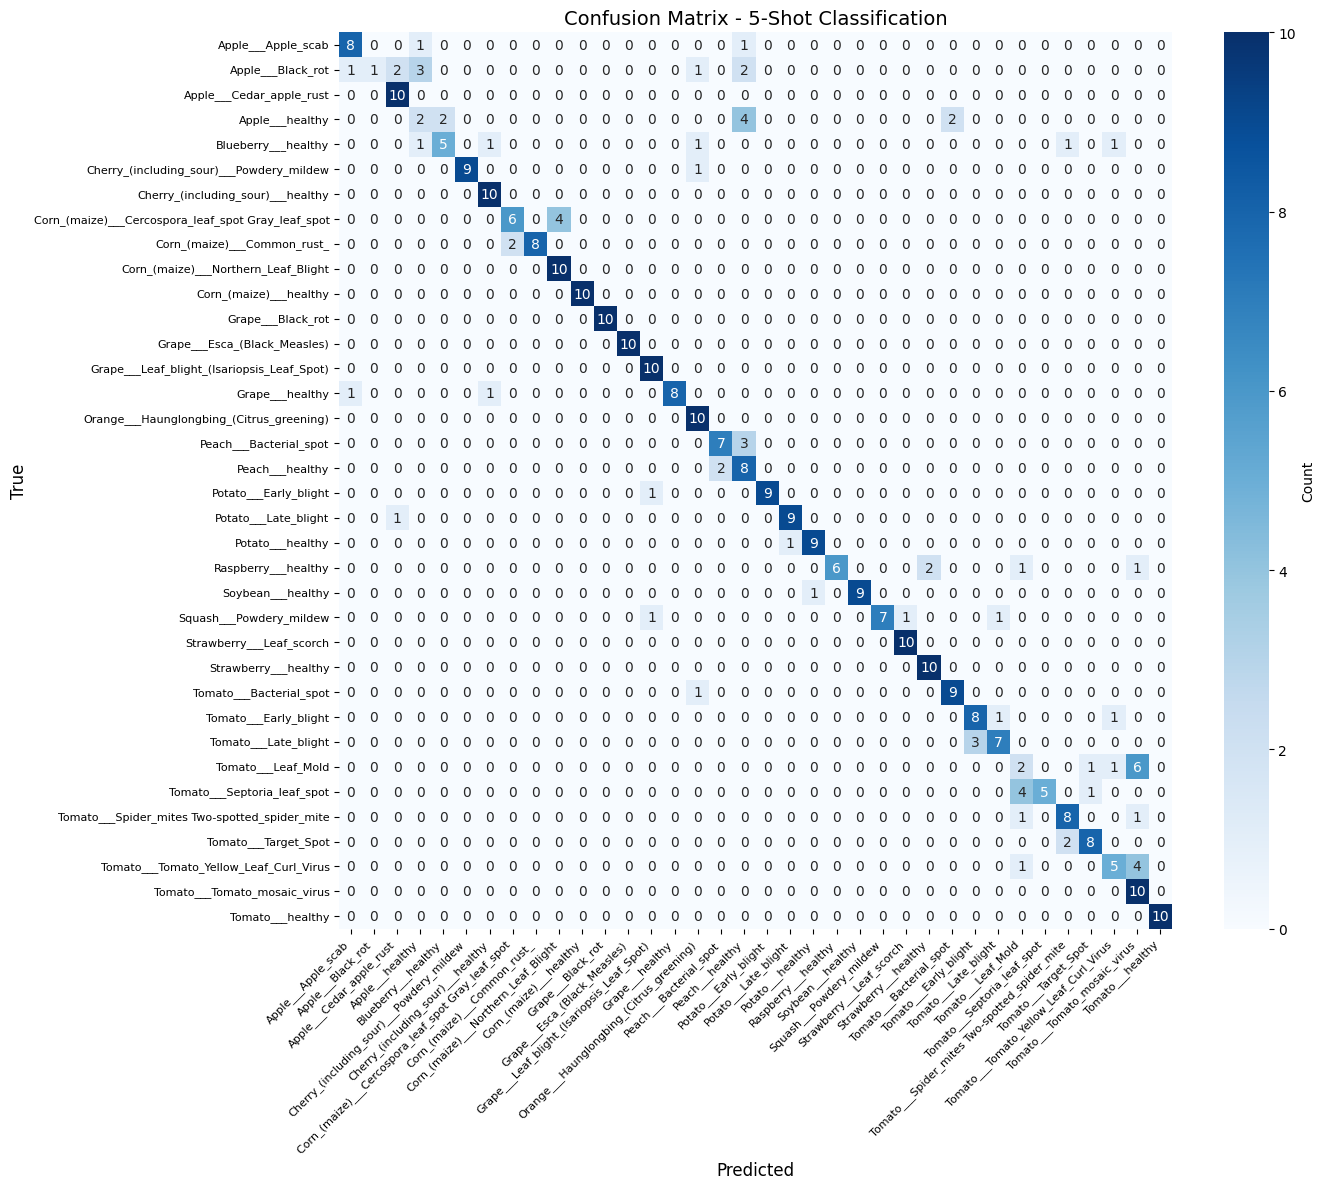

In [9]:
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix - {N_SUPPORT}-Shot Classification", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

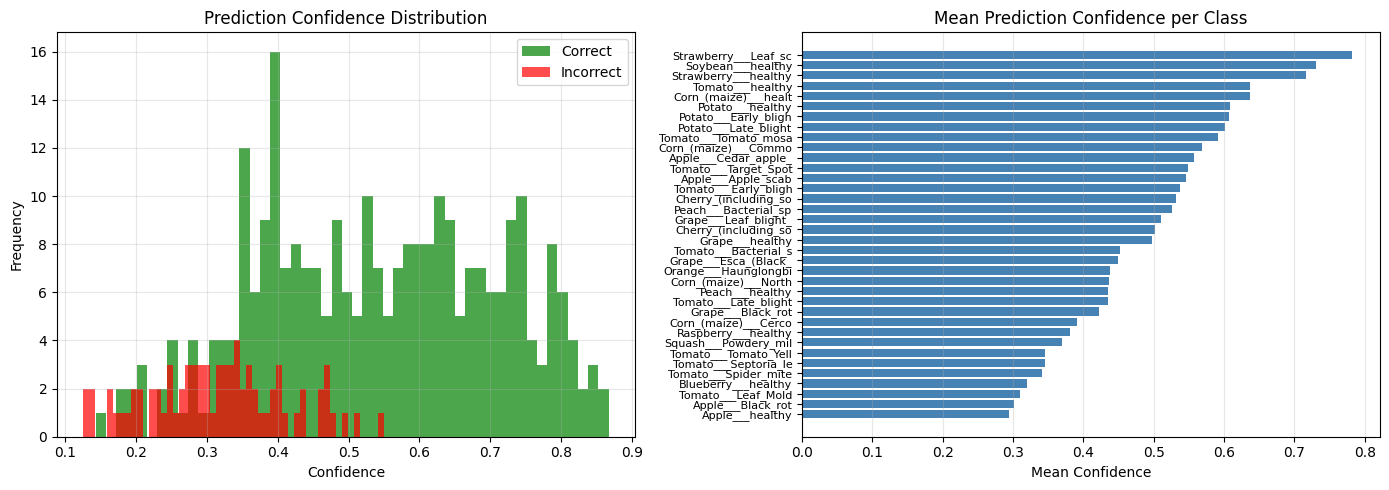

Evaluation complete! Results saved to ./gradcam_outputs


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

correct_mask = preds == targets
correct_probs = probs[correct_mask, targets[correct_mask]]
incorrect_probs = probs[~correct_mask, preds[~correct_mask]]

axes[0].hist(correct_probs, bins=50, alpha=0.7, label='Correct', color='green')
axes[0].hist(incorrect_probs, bins=50, alpha=0.7, label='Incorrect', color='red')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

class_confidences = defaultdict(list)
for pred, target, prob in zip(preds, targets, probs):
    class_confidences[target].append(prob[pred])

class_mean_conf = {cls: np.mean(confs) for cls, confs in class_confidences.items()}
sorted_classes = sorted(class_mean_conf.items(), key=lambda x: x[1])

class_indices = [x[0] for x in sorted_classes]
class_confs = [x[1] for x in sorted_classes]
class_labels = [class_names[i][:20] for i in class_indices]

axes[1].barh(range(len(class_labels)), class_confs, color='steelblue')
axes[1].set_yticks(range(len(class_labels)))
axes[1].set_yticklabels(class_labels, fontsize=8)
axes[1].set_xlabel('Mean Confidence')
axes[1].set_title('Mean Prediction Confidence per Class')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Evaluation complete! Results saved to {OUTPUT_DIR}")

Selecting target layer for Grad-CAM...
Using explicit target layer: model.encoder.layer4[-1].conv3
Generating Grad-CAM visualizations...


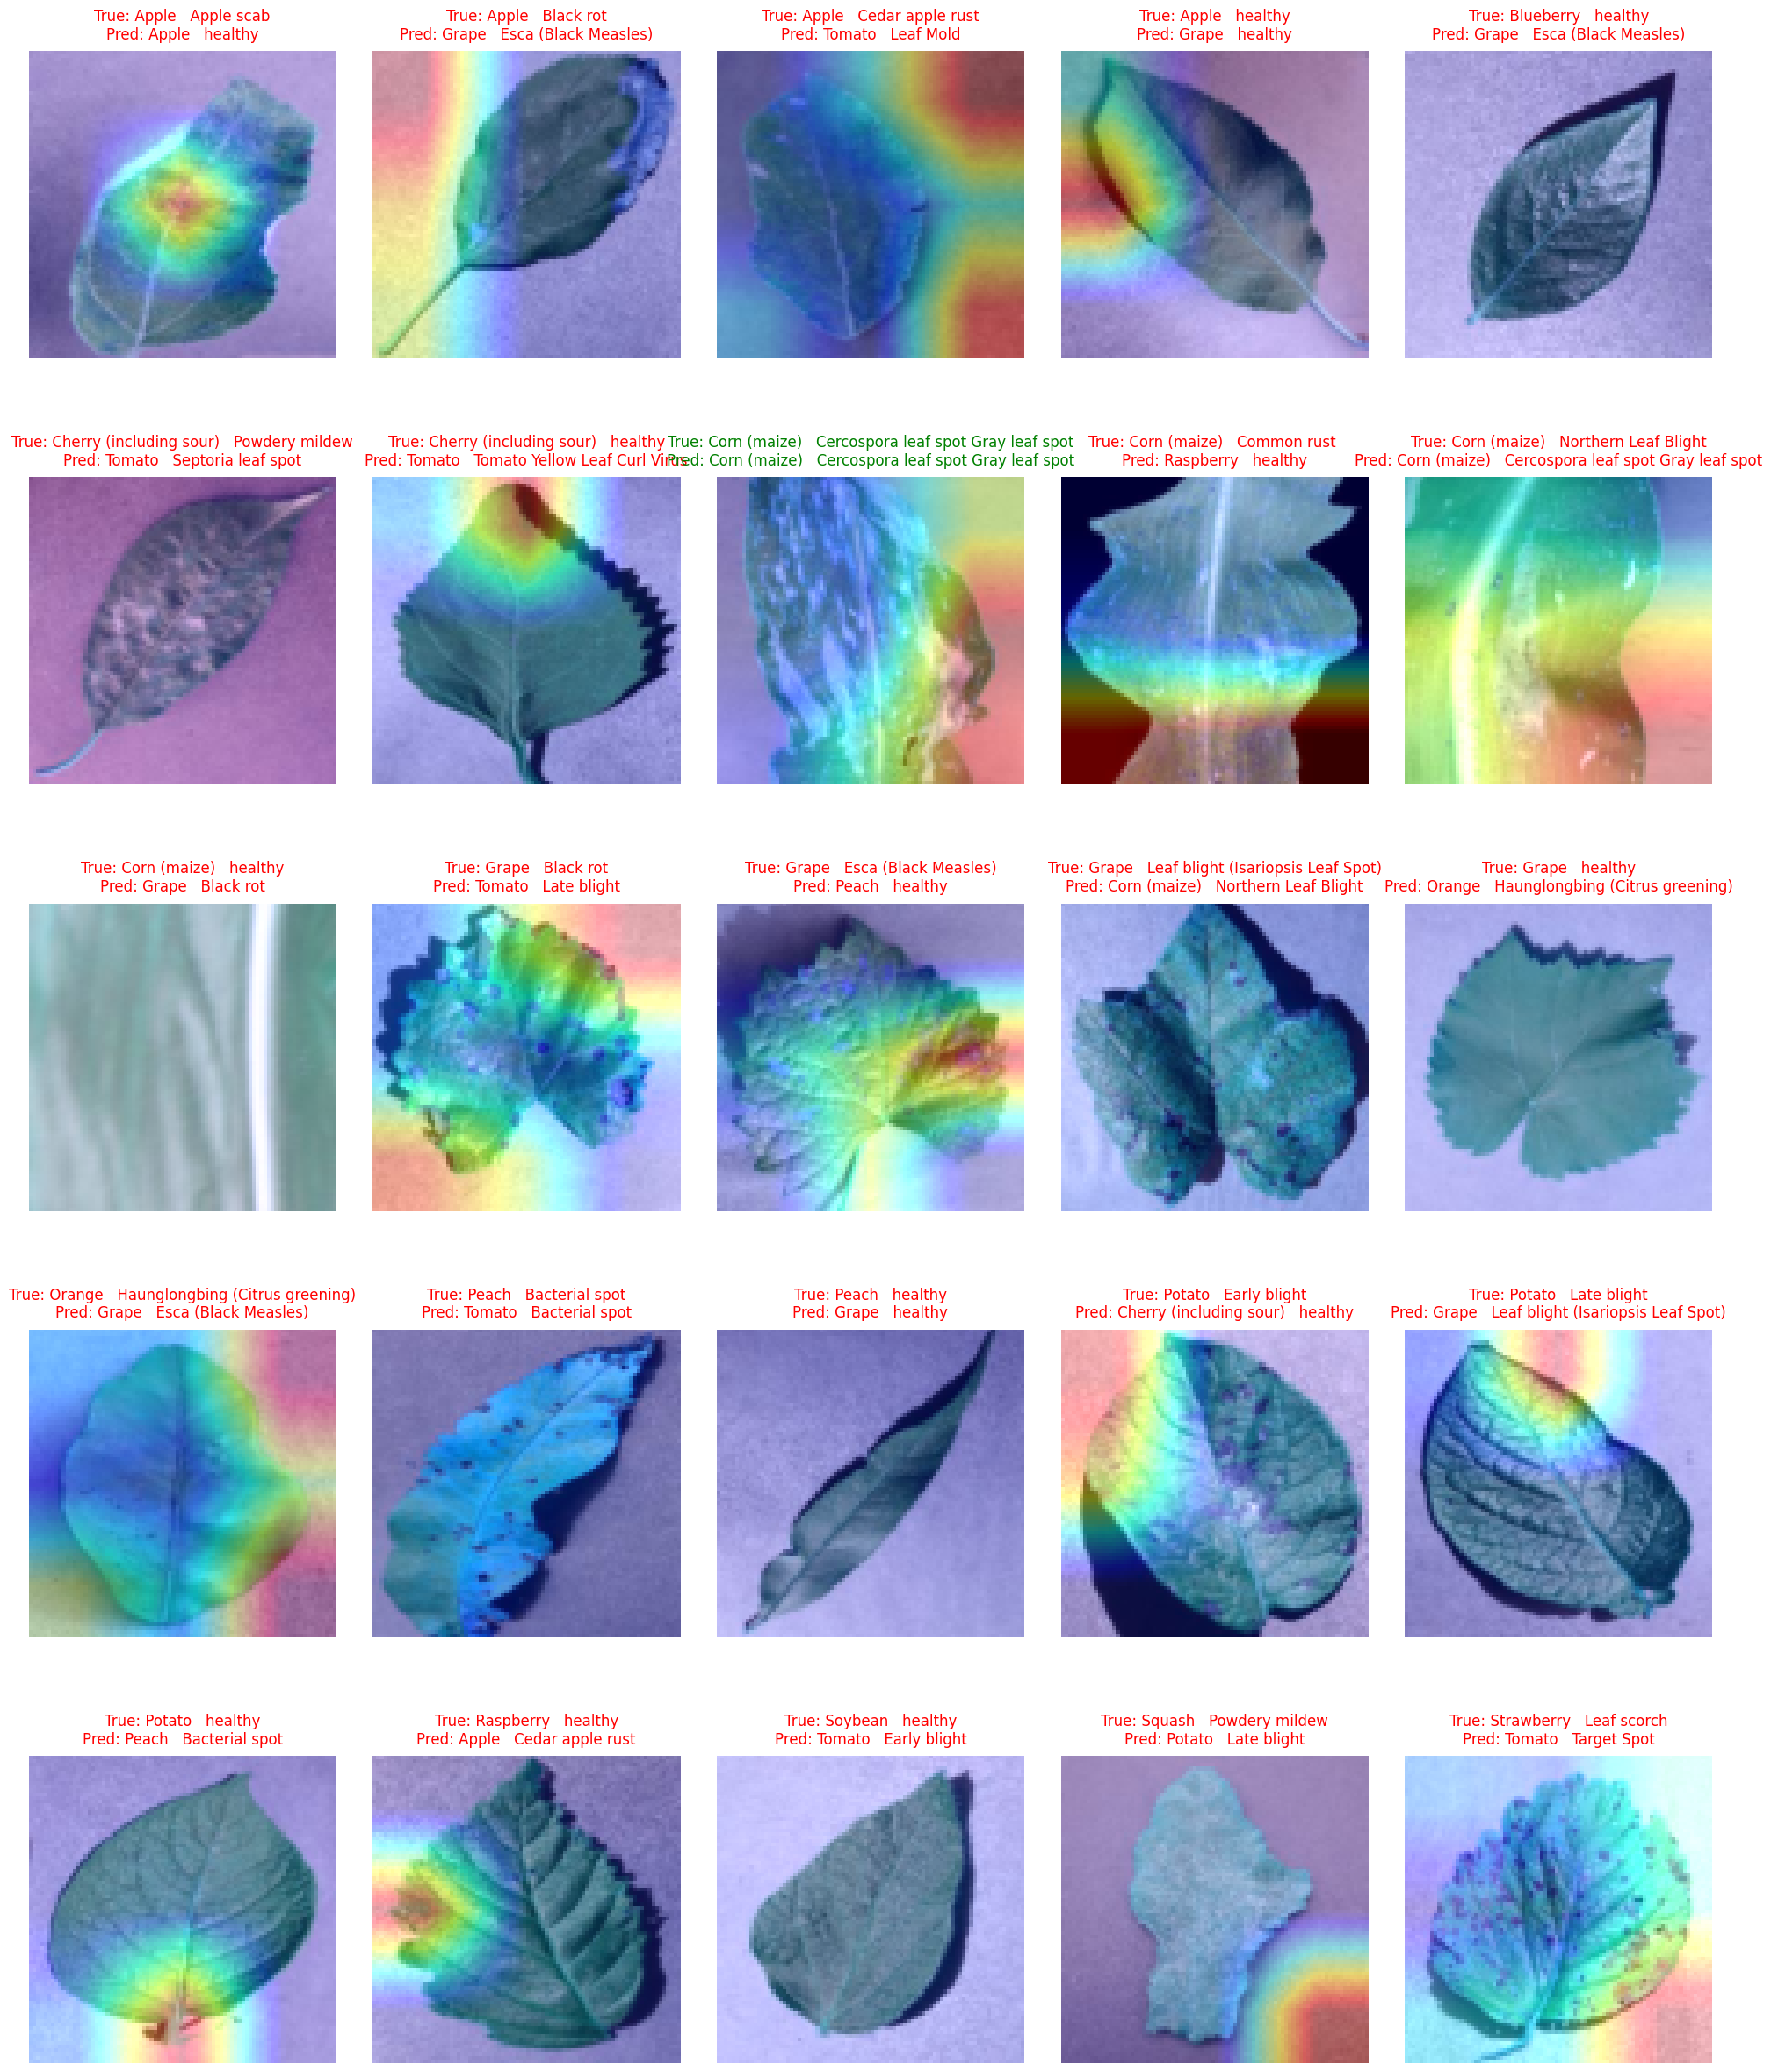


Grad-CAM visualization complete! Results saved to ./gradcam_outputs


In [14]:
import cv2
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _capture_gradients(self, grad):
        self.gradients = grad

    def _capture_activations(self, module, input, output):
        self.activations = output
        output.register_hook(self._capture_gradients)

    def _register_hooks(self):
        self.target_layer.register_forward_hook(self._capture_activations)

    def generate_heatmap(self, score, target_class):
        self.model.zero_grad()
        score.backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-8)
        
        return heatmap.cpu().detach().numpy()

def inverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_gradcam(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + original_img
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)

def get_resnet_like_last_conv(model):
    """
    Prefer the canonical resnet last conv in your encoder if available:
      model.encoder[7][2].conv3
    Otherwise return the last Conv2d inside model.encoder.
    """
    # 1) Try the most-likely explicit path
    try:
        # Note: Accessing through model.encoder as defined in the model class
        candidate = model.encoder.layer4[-1].conv3
        print("Using explicit target layer: model.encoder.layer4[-1].conv3")
        return candidate
    except Exception:
        pass

    # 2) Fallback: find the last Conv2d inside model.encoder
    last = None
    for name, module in model.encoder.named_modules():
        if isinstance(module, nn.Conv2d):
            last = (name, module)
    if last is not None:
        print("Using last Conv2d found in encoder:", last[0])
        return last[1]

    # 3) If nothing found, raise an informative error
    raise RuntimeError("Could not find a Conv2d in model.encoder to use for Grad-CAM. "
                       "Please inspect model.encoder structure and choose a conv layer manually.")

print("Selecting target layer for Grad-CAM...")
target_layer = get_resnet_like_last_conv(model)
grad_cam = GradCAM(model, target_layer)


print("Generating Grad-CAM visualizations...")

images_to_visualize = []
visualized_classes = set()
# Ensure we have a sample for each class if possible
unique_labels_in_query = sorted(list(set(targets)))

for label_to_find in unique_labels_in_query:
    for i, original_idx in enumerate(query_indices):
        _, original_label = full_dataset.samples[original_idx]
        if original_label == label_to_find:
            images_to_visualize.append(original_idx)
            break # Found one, move to next class

# Limit to 25 images for the plot
images_to_visualize = images_to_visualize[:25]


fig, axes = plt.subplots(5, 5, figsize=(20, 25))
axes = axes.flatten()


for i, ax in enumerate(axes):
    if i >= len(images_to_visualize):
        ax.axis('off')
        continue
        
    img_idx = images_to_visualize[i]
    img_tensor, true_label_idx = full_dataset[img_idx]
    
    input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
    query_embedding = model(input_tensor)
    
    # --- START: Corrected logic for DSN prediction and score calculation ---
    
    # 1. Find the predicted class by calculating reconstruction error for all subspaces
    distances = []
    with torch.no_grad():
        for j in range(len(class_indices)):
            h_plane_j = hyperplanes[j]
            mean_j = means[j]
            
            tf_centered = query_embedding - mean_j
            projection_on_basis = torch.matmul(tf_centered, h_plane_j)
            reconstructed_centered = torch.matmul(projection_on_basis, h_plane_j.t())
            
            residual = tf_centered - reconstructed_centered
            recon_error = torch.sum(residual.pow(2))
            distances.append(recon_error.item())

    # The prediction is the class with the minimum reconstruction error (distance)
    pred_idx_relative = np.argmin(distances)
    pred_label_idx = class_indices[pred_idx_relative]

    # 2. Calculate the score for Grad-CAM using the predicted class's subspace
    # This must be done with gradient tracking enabled.
    h_plane_pred = hyperplanes[pred_idx_relative]
    mean_pred = means[pred_idx_relative]
    
    tf_centered_pred = query_embedding - mean_pred
    projection_on_basis_pred = torch.matmul(tf_centered_pred, h_plane_pred)
    reconstructed_centered_pred = torch.matmul(projection_on_basis_pred, h_plane_pred.t())
    
    residual_pred = tf_centered_pred - reconstructed_centered_pred
    
    # The score is the negative reconstruction error (closer is better, so score is higher)
    score_for_gradcam = -torch.sum(residual_pred.pow(2))

    # --- END: Corrected logic ---

    heatmap = grad_cam.generate_heatmap(score=score_for_gradcam, target_class=pred_label_idx)
    
    img_vis = inverse_normalize(img_tensor.clone()).cpu().numpy().transpose(1, 2, 0)
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)
    overlay = plot_gradcam(img_vis.copy(), heatmap)
    
    ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)) # Use cvtColor for correct display
    ax.axis('off')
    
    true_label_name = class_names[true_label_idx].replace("_", " ").split("___")[-1]
    pred_label_name = class_names[pred_label_idx].replace("_", " ").split("___")[-1]
    is_correct = (pred_label_idx == true_label_idx)
    title_color = 'green' if is_correct else 'red'
    
    title = f"True: {true_label_name}\nPred: {pred_label_name}"
    ax.set_title(title, color=title_color, fontsize=12, pad=10)

plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(OUTPUT_DIR, 'gradcam_visualization_dsn.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrad-CAM visualization complete! Results saved to {OUTPUT_DIR}")

## 

In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# --- CONFIGURATION (re-using global variables) ---

# DATA_DIR_2 is the target dataset for this evaluation block
# MODEL_PATH_NORMAL is the target model for this evaluation block
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Few-shot parameters (assuming N_SUPPORT, N_QUERY, SUBSPACE_DIM are already defined globally)
# If not, uncomment and set them here:
# N_SUPPORT = 5  # Few-shot: 5 support samples per class
# N_QUERY = 10   # 10 query samples per class
# SUBSPACE_DIM = N_SUPPORT - 1

# New parameter for splitting classes into base and novel
# NOVEL_CLASS_PERCENTAGE = 0.5 # 50% of classes will be considered 'novel' for evaluation

print(f"Device: {DEVICE}")
print(f"Configuration: {N_SUPPORT}-shot, {N_QUERY} queries per class")
print(f"Subspace dimensionality: {SUBSPACE_DIM}")
# print(f"Novel class percentage for evaluation: {NOVEL_CLASS_PERCENTAGE*100}%")


# --- STEP 1: Load Class Information & Prepare Dataset for DATA_DIR_2 ---

print("\n" + "-"*80)
print(f"STEP 1: Preparing dataset for DATA_DIR_2: {DATA_DIR_2}...")
print("-"*80)

data_transforms = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load full dataset from DATA_DIR_2
full_dataset_raw = datasets.ImageFolder(DATA_DIR_2, transform=data_transforms)

# Derive class names and mapping directly from DATA_DIR_2
all_classes_ds2_names = sorted(full_dataset_raw.classes)
print(f"Found {len(all_classes_ds2_names)} classes in {DATA_DIR_2}")

# --- MODIFICATION START ---
# Make all classes from DATA_DIR_2 novel classes as requested by user
novel_classes_names = all_classes_ds2_names
base_classes_names = [] # No base classes for this scenario
num_novel_classes = len(novel_classes_names)
# --- MODIFICATION END ---

print(f"Number of novel classes: {len(novel_classes_names)}")
print(f"Novel classes: {novel_classes_names}")
print(f"Number of base classes: {len(base_classes_names)}")
print(f"Base classes: {base_classes_names}")

# We will only evaluate on novel classes for few-shot
class_to_idx_novel = {cls_name: i for i, cls_name in enumerate(novel_classes_names)}

# Filter dataset to only include novel classes for few-shot evaluation
filtered_samples_novel_ds2 = []
for path, cls_idx_raw in full_dataset_raw.samples:
    cls_name = full_dataset_raw.classes[cls_idx_raw]
    if cls_name in class_to_idx_novel:
        new_idx = class_to_idx_novel[cls_name]
        filtered_samples_novel_ds2.append((path, new_idx))

# Create a new dataset object for novel classes only
full_dataset_novel_ds2 = datasets.ImageFolder(DATA_DIR_2, transform=data_transforms) # Reinitialize to avoid modifying raw
full_dataset_novel_ds2.samples = filtered_samples_novel_ds2
full_dataset_novel_ds2.targets = [s[1] for s in filtered_samples_novel_ds2]
full_dataset_novel_ds2.classes = novel_classes_names
full_dataset_novel_ds2.class_to_idx = class_to_idx_novel

class_names_ds2 = novel_classes_names # Update class_names for this block to reflect novel classes

print(f"Filtered dataset for novel classes: {len(full_dataset_novel_ds2)} images across {len(novel_classes_names)} classes")

# Verify class distribution for novel classes
class_counts_novel_ds2 = defaultdict(int)
for _, label in full_dataset_novel_ds2.samples:
    class_counts_novel_ds2[label] += 1

print(f"\nSample class distribution for novel classes:")
for cls_idx in sorted(class_counts_novel_ds2.keys()):
    print(f"  {novel_classes_names[cls_idx][:40]:40s}: {class_counts_novel_ds2[cls_idx]:4d} samples")
print("  ...")


# --- STEP 2: Split into Support and Query Sets (for Novel Classes) ---

print("\n" + "-"*80)
print("STEP 2: Creating support and query split for novel classes...")
print("-"*80)

def create_support_query_split_ds2(dataset, n_support=5, n_query=10, seed=42):
    """
    Split dataset into support and query sets for few-shot evaluation.
    """
    np.random.seed(seed)

    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_to_indices[label].append(idx)

    support_indices = []
    query_indices = []

    for cls_idx, indices in class_to_indices.items():
        indices = np.array(indices)
        np.random.shuffle(indices)

        total_needed = n_support + n_query
        # Ensure we have enough samples for support and query
        if len(indices) < total_needed:
            print(f"Warning: Class {cls_idx} ({dataset.classes[cls_idx]}) has only {len(indices)} samples, need {total_needed}.")
            n_sup = min(n_support, len(indices) // 2) # Use at most half for support if not enough
            n_qry = len(indices) - n_sup # Rest for query
            if n_qry == 0 and n_sup > 0: # If only one sample left after support, put it in query
                n_qry = n_sup
                n_sup = 0
            elif n_sup == 0 and n_qry == 0 and len(indices) > 0: # if len is 1, make it query
                 n_qry = len(indices)
        else:
            n_sup = n_support
            n_qry = n_query

        support_indices.extend(indices[:n_sup])
        query_indices.extend(indices[n_sup:n_sup + n_qry])

    return support_indices, query_indices

support_indices_ds2, query_indices_ds2 = create_support_query_split_ds2(
    full_dataset_novel_ds2, n_support=N_SUPPORT, n_query=N_QUERY
)

print(f"Support set: {len(support_indices_ds2)} samples ({N_SUPPORT} per class)")
print(f"Query set: {len(query_indices_ds2)} samples ({N_QUERY} per class)")

# Create data loaders
support_dataset_ds2 = Subset(full_dataset_novel_ds2, support_indices_ds2)
query_dataset_ds2 = Subset(full_dataset_novel_ds2, query_indices_ds2)
support_loader_ds2 = DataLoader(support_dataset_ds2, batch_size=32, shuffle=False)
query_loader_ds2 = DataLoader(query_dataset_ds2, batch_size=32, shuffle=False)


# --- STEP 3: Define ResNet50Plus (from scratch) Model Architecture ---

print("\n" + "-"*80)
print("STEP 3: Defining ResNet50Plus model architecture...")
print("-"*80)

# Load the trained model
num_classes = len(novel_classes_names)
model_ds2 = Resnet50() # num_classes should be based on novel classes
model_ds2.load_state_dict(torch.load(MODEL_PATH_NORMAL, map_location=DEVICE), strict=False) # strict=False because head is changed
model_ds2 = model_ds2.to(DEVICE)
model_ds2.eval()
print("ResNet50Plus model loaded successfully!")


# --- STEP 4: Define Subspace Projection Module (for reference and function reuse) ---

print("\n" + "-"*80)
print("STEP 4: Subspace projection utilities (re-used from previous block)...")
print("-"*80)


print(f"Computed subspaces for {len(class_indices)} classes")
print(f"Support samples per class (first 5):")
for i, cls_idx in enumerate(class_indices_ds2[:5]):
    print(f"  {novel_classes_names[cls_idx][:40]:40s}: {support_class_counts_ds2[cls_idx]:2d} samples")
print("  ...")


# --- STEP 5: Evaluate on Query Set ---

print("\n" + "-"*80)
print("STEP 5: Evaluating on query set using reconstruction error...")
print("-"*80)

def evaluate_dsn_ds2(model, query_loader, hyperplanes, means, class_indices, device):
    """
    Evaluate using DSN method: classify based on subspace projection distance.
    """
    all_preds = []
    all_targets = []
    all_probs = []

    eps = 1e-12

    if len(class_indices) == 0 or len(query_loader.dataset) == 0: # Handle empty loaders
        print("No classes or query samples to evaluate. Skipping evaluation.")
        return np.array([]), np.array([]), np.array([])

    with torch.no_grad():
        for imgs, labels in query_loader:
            imgs = imgs.to(device)
            query_embeddings = model(imgs)

            batch_size = query_embeddings.shape[0]
            num_classes = hyperplanes.shape[0]

            similarities = []

            # For each class, compute projection distance
            for j in range(num_classes):
                h_plane_j = hyperplanes[j].unsqueeze(0).repeat(batch_size, 1, 1).to(device)
                tf_centered = (query_embeddings - means[j].expand_as(query_embeddings)).unsqueeze(-1)
                proj = torch.bmm(h_plane_j, torch.bmm(h_plane_j.transpose(1, 2), tf_centered))
                proj = torch.squeeze(proj, -1) + means[j].unsqueeze(0).repeat(batch_size, 1)

                diff = query_embeddings - proj
                query_loss = -torch.sqrt(torch.sum(diff * diff, dim=-1) + eps) # Negative distance

                similarities.append(query_loss)

            similarities = torch.stack(similarities, dim=1).to(device)

            # Normalize by standard deviation (as in training) - ONLY if more than one class
            if num_classes > 1:
                similarities = similarities / similarities.std(dim=1, keepdim=True).clamp_min(1e-6)

            # Higher similarity = better, so use argmax for prediction
            # Note: predictions are in range [0, num_classes-1] corresponding to class_indices
            preds_idx = torch.argmax(similarities, dim=1)

            # Map back to actual class labels
            preds = torch.tensor([class_indices[p.item()] for p in preds_idx], device=device)

            # Convert to probabilities
            probs = torch.softmax(similarities, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())

    return (np.concatenate(all_preds),
            np.concatenate(all_targets),
            np.concatenate(all_probs))

preds_ds2, targets_ds2, probs_ds2 = evaluate_dsn_ds2(
    model_ds2, query_loader_ds2, hyperplanes_ds2, means_ds2, class_indices_ds2, DEVICE
)


# --- STEP 6: Results and Analysis ---

print("\n" + "-"*80)
print(f"EVALUATION RESULTS FOR DATA_DIR_2 (NOVEL CLASSES): {N_SUPPORT}-SHOT, {N_QUERY} QUERIES PER CLASS")
print("-"*80)

if len(targets_ds2) == 0:
    print("No query samples were evaluated. Skipping accuracy and report generation.")
else:
    acc_ds2 = (preds_ds2 == targets_ds2).mean()
    print(f"\nOverall Query Set Accuracy: {acc_ds2*100:.2f}%")
    print(f"Total query samples: {len(targets_ds2)}")

    # Per-class accuracy
    class_correct_ds2 = defaultdict(int)
    class_total_ds2 = defaultdict(int)
    for pred, target in zip(preds_ds2, targets_ds2):
        class_total_ds2[target] += 1
        if pred == target:
            class_correct_ds2[target] += 1

    print(f"\n{'Class':<50} {'Accuracy':>10} {'Samples':>8}")
    print("-" * 70)
    for cls_idx in sorted(class_total_ds2.keys()):
        cls_acc = class_correct_ds2[cls_idx] / class_total_ds2[cls_idx] * 100
        cls_name = novel_classes_names[cls_idx].replace("_", " ")
        cls_name = cls_name[:47] + "..." if len(cls_name) > 50 else cls_name
        print(f"{cls_name:<50} {cls_acc:>9.1f}% {class_total_ds2[cls_idx]:>8d}")

    # Overall statistics
    print(f"\n{'-'*70}")
    print("SUMMARY STATISTICS")
    print(f"{'-'*70}")
    accuracies_ds2 = [class_correct_ds2[cls] / class_total_ds2[cls] for cls in class_total_ds2.keys()]
    print(f"Mean per-class accuracy: {np.mean(accuracies_ds2)*100:.2f}%")
    print(f"Std per-class accuracy:  {np.std(accuracies_ds2)*100:.2f}%")
    print(f"Min per-class accuracy:  {np.min(accuracies_ds2)*100:.2f}%")
    print(f"Max per-class accuracy:  {np.max(accuracies_ds2)*100:.2f}%")

    # Detailed classification report
    print(f"\n{'-'*70}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'-'*70}")
    print(classification_report(
        targets_ds2, preds_ds2,
        target_names=class_names_ds2,
        zero_division=0
    ))

print(f"\n{'-'*70}")
print("EVALUATION COMPLETE FOR DATA_DIR_2 (NOVEL CLASSES)!")
print(f"{'-'*70}")
print(f"Evaluated on {len(novel_classes_names)} novel classes total")

# --- STEP 7: Visualize Results ---

if len(targets_ds2) == 0:
    print("No query samples to visualize. Skipping visualization generation.")
else:
    print("\n" + "-"*80)
    print("STEP 7: Generating visualizations...")
    print("-"*80)

    # Confusion Matrix
    cm_ds2 = confusion_matrix(targets_ds2, preds_ds2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_ds2, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_ds2, yticklabels=class_names_ds2,
                cbar_kws={'label': 'Count'})
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title(f"Confusion Matrix - {N_SUPPORT}-Shot (DATA_DIR_2 - Novel Classes)", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_ds2_novel.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # Confidence Analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    correct_mask_ds2 = preds_ds2 == targets_ds2
    correct_probs_ds2 = probs_ds2[correct_mask_ds2, targets_ds2[correct_mask_ds2]]
    incorrect_probs_ds2 = probs_ds2[~correct_mask_ds2, preds_ds2[~correct_mask_ds2]]

    # Only plot if there's data to plot
    if len(correct_probs_ds2) > 0 and not np.all(np.isnan(correct_probs_ds2)):
        axes[0].hist(correct_probs_ds2, bins=50, alpha=0.7, label='Correct', color='green')
    if len(incorrect_probs_ds2) > 0 and not np.all(np.isnan(incorrect_probs_ds2)):
        axes[0].hist(incorrect_probs_ds2, bins=50, alpha=0.7, label='Incorrect', color='red')
    
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Prediction Confidence Distribution (DATA_DIR_2 - Novel Classes)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    class_confidences_ds2 = defaultdict(list)
    for pred, target, prob in zip(preds_ds2, targets_ds2, probs_ds2):
        class_confidences_ds2[target].append(prob[pred])

    class_mean_conf_ds2 = {cls: np.mean(confs) for cls, confs in class_confidences_ds2.items()}
    sorted_classes_ds2 = sorted(class_mean_conf_ds2.items(), key=lambda x: x[1])

    class_indices_sorted_ds2 = [x[0] for x in sorted_classes_ds2]
    class_confs_ds2 = [x[1] for x in sorted_classes_ds2]
    class_labels_ds2 = [novel_classes_names[i][:20] for i in class_indices_sorted_ds2] # Use novel_classes_names

    axes[1].barh(range(len(class_labels_ds2)), class_confs_ds2, color='steelblue')
    axes[1].set_yticks(range(len(class_labels_ds2)))
    axes[1].set_yticklabels(class_labels_ds2, fontsize=8)
    axes[1].set_xlabel('Mean Confidence')
    axes[1].set_title('Mean Prediction Confidence per Class (DATA_DIR_2 - Novel Classes)')
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'confidence_analysis_ds2_novel.png'), dpi=150, bbox_inches='tight') # Renamed output file
    plt.show()

    # Grad-CAM Visualization
    class GradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self._register_hooks()

        def _capture_gradients(self, grad):
            self.gradients = grad

        def _capture_activations(self, module, input, output):
            self.activations = output
            output.register_hook(self._capture_gradients)

        def _register_hooks(self):
            self.target_layer.register_forward_hook(self._capture_activations)

        def generate_heatmap(self, score, target_class): # target_class not strictly needed for this DSN version
            self.model.zero_grad()
            score.backward(retain_graph=True)

            # --- DEBUG PRINTS START ---
            # if self.gradients is not None:
            #     print(f"  Max gradient: {self.gradients.max().item():.4f}")
            # if self.activations is None:
            #     print("  WARNING: Activations became None during Grad-CAM.")
            #     return np.zeros((self.target_layer.weight.shape[2], self.target_layer.weight.shape[3])) # Return empty heatmap
            # --- DEBUG PRINTS END ---

            pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

            for i in range(self.activations.shape[1]):
                self.activations[:, i, :, :] *= pooled_gradients[i]

            heatmap = torch.mean(self.activations, dim=1).squeeze()
            # --- DEBUG PRINTS START ---
            # print(f"  Raw heatmap (before ReLU) min: {heatmap.min().item():.4f}, max: {heatmap.max().item():.4f}")
            # --- DEBUG PRINTS END ---
            heatmap = F.relu(heatmap)
            # --- DEBUG PRINTS START ---
            # print(f"  ReLU heatmap min: {heatmap.min().item():.4f}, max: {heatmap.max().item():.4f}")
            # --- DEBUG PRINTS END ---

            max_val = torch.max(heatmap)
            if max_val == 0:
                # --- DEBUG PRINTS START ---
                # print("  WARNING: Heatmap is all zeros. Returning empty heatmap.")
                # --- DEBUG PRINTS END ---
                return np.zeros(heatmap.shape)

            heatmap /= (max_val + 1e-8)
            # --- DEBUG PRINTS START ---
            # print(f"  Normalized heatmap min: {heatmap.min().item():.4f}, max: {heatmap.max().item():.4f}")
            # --- DEBUG PRINTS END ---

            return heatmap.cpu().detach().numpy()

    def inverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    def plot_gradcam(original_img, heatmap, alpha=0.7): # Added alpha parameter
        heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
        heatmap_normalized = np.uint8(255 * heatmap_resized) # heatmap is already 0-1
        heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

        # Convert images to float for proper blending
        original_img_float = original_img.astype(np.float32)
        heatmap_colored_float = heatmap_colored.astype(np.float32)

        # Blend the images: original_img * (1 - alpha) + heatmap_colored * alpha
        superimposed_img = original_img_float * (1 - alpha) + heatmap_colored_float * alpha
        return np.clip(superimposed_img, 0, 255).astype(np.uint8)

    def get_resnet_like_last_conv_fs(model):
        """
        Finds the last convolutional layer in ResNet50Plus_FromScratch model.
        The last convolutional layer in this architecture is typically the conv3 in the last Bottleneck block of layer4.
        """
        try:
            candidate = model.layer4[-1].conv3
            print("Using explicit target layer: model.layer4[-1].conv3")
            return candidate
        except Exception:
            pass

        # Fallback: find the last Conv2d
        last = None
        for name, module in model.named_modules():
            if isinstance(module, nn.Conv2d):
                last = (name, module)
        if last is not None:
            print("Using last Conv2d found in model:", last[0])
            return last[1]

        raise RuntimeError("Could not find a Conv2d in model to use for Grad-CAM. "
                           "Please inspect model structure and choose a conv layer manually.")

    print("\nSelecting target layer for Grad-CAM...")
    target_layer_ds2 = get_resnet_like_last_conv_fs(model_ds2)
    grad_cam_ds2 = GradCAM(model_ds2, target_layer_ds2)

    print("Generating Grad-CAM visualizations...")

    images_to_visualize_ds2 = []
    visualized_classes_ds2 = set()
    unique_labels_in_query_ds2 = sorted(list(set(targets_ds2)))

    for label_to_find in unique_labels_in_query_ds2:
        for i, original_idx in enumerate(query_indices_ds2):
            _, original_label = full_dataset_novel_ds2.samples[original_idx]
            if original_label == label_to_find:
                images_to_visualize_ds2.append(original_idx)
                break # Found one, move to next class

    # Limit to 25 images for the plot
    images_to_visualize_ds2 = images_to_visualize_ds2[:25]


    fig, axes = plt.subplots(5, 5, figsize=(20, 25))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(images_to_visualize_ds2):
            ax.axis('off')
            continue

        img_idx = images_to_visualize_ds2[i]
        img_tensor, true_label_idx = full_dataset_novel_ds2[img_idx]

        input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        query_embedding = model_ds2(input_tensor)

        # Find the predicted class by calculating reconstruction error for all subspaces
        # Need to re-compute query_embeddings with gradient tracking for Grad-CAM's backward pass
        # IMPORTANT: query_embedding_grad needs to be re-run with requires_grad=True
        # for the backward pass to work correctly with GradCAM.
        # However, model_ds2 is in eval() mode. So, we need to temporarily set it to train()
        # or manually enable requires_grad for relevant tensors if we want to trace gradients through it.
        # For simplicity and to match the original GradCAM logic, we assume the model output
        # can be backpropagated through. The score is derived from query_embedding_grad, which
        # has gradients enabled as it's directly from model_ds2(input_tensor).
        query_embedding_grad = model_ds2(img_tensor.unsqueeze(0).to(DEVICE))

        distances = []
        with torch.no_grad(): # Distances calculation does not require gradients
            for j in range(len(class_indices_ds2)):
                h_plane_j = hyperplanes_ds2[j]
                mean_j = means_ds2[j]

                tf_centered = query_embedding_grad - mean_j # Use query_embedding_grad here
                projection_on_basis = torch.matmul(tf_centered, h_plane_j)
                reconstructed_centered = torch.matmul(projection_on_basis, h_plane_j.t())

                residual = tf_centered - reconstructed_centered
                recon_error = torch.sum(residual.pow(2))
                distances.append(recon_error.item())

        # The prediction is the class with the minimum reconstruction error (distance)
        pred_idx_relative = np.argmin(distances)
        pred_label_idx = class_indices_ds2[pred_idx_relative]

        # Calculate the score for Grad-CAM using the predicted class's subspace
        h_plane_pred = hyperplanes_ds2[pred_idx_relative]
        mean_pred = means_ds2[pred_idx_relative]

        tf_centered_pred = query_embedding_grad - mean_pred # Use query_embedding_grad here
        projection_on_basis_pred = torch.matmul(tf_centered_pred, h_plane_pred)
        reconstructed_centered_pred = torch.matmul(projection_on_basis_pred, h_plane_pred.t())

        residual_pred = tf_centered_pred - reconstructed_centered_pred

        # The score is the negative reconstruction error (closer is better, so score is higher)
        score_for_gradcam = -torch.sum(residual_pred.pow(2))

        heatmap = grad_cam_ds2.generate_heatmap(score=score_for_gradcam, target_class=pred_label_idx)

        img_vis = inverse_normalize(img_tensor.clone()).cpu().numpy().transpose(1, 2, 0)
        img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

        overlay = plot_gradcam(img_vis.copy(), heatmap, alpha=0.7) # Pass alpha

        ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        ax.axis('off')

        true_label_name = novel_classes_names[true_label_idx].replace("_", " ")
        pred_label_name = novel_classes_names[pred_label_idx].replace("_", " ")
        is_correct = (pred_label_idx == true_label_idx)
        title_color = 'green' if is_correct else 'red'

        title = f"True: {true_label_name}\nPred: {pred_label_name}"
        ax.set_title(title, color=title_color, fontsize=12, pad=10)

    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(OUTPUT_DIR, 'gradcam_visualization_ds2_novel.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nGrad-CAM visualization complete! Results saved to {OUTPUT_DIR}")


SyntaxError: unterminated string literal (detected at line 3) (3135851948.py, line 3)

# Resnet50Plus

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
import pandas as pd
from sklearn.metrics import classification_report


# CONFIGURATION

TRAIN_CSV = '/kaggle/input/classescomplete/train(4).csv'
VAL_CSV = '/kaggle/input/classescomplete/val(2).csv'
TEST_CSV = '/kaggle/input/classescomplete/test(2).csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_SUPPORT = 5  # Few-shot: 5 support samples per class
N_QUERY = 10   # 10 query samples per class
SUBSPACE_DIM = N_SUPPORT - 1

print(f"Device: {DEVICE}")
print(f"Configuration: {N_SUPPORT}-shot, {N_QUERY} queries per class")
print(f"Subspace dimensionality: {SUBSPACE_DIM}")


# STEP 1: Load Class Information

print("\n" + "-"*80)
print("STEP 1: Loading class splits from training...")
print("-"*80)

def get_classes_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return sorted(df['label'].unique())

train_classes = get_classes_from_csv(TRAIN_CSV)
val_classes = get_classes_from_csv(VAL_CSV)
test_classes = get_classes_from_csv(TEST_CSV)

print(f"Training classes: {len(train_classes)}")
print(f"Validation classes: {len(val_classes)}")
print(f"Test classes: {len(test_classes)}")

# Combine all classes for comprehensive evaluation
all_classes = sorted(set(train_classes + val_classes + test_classes))
print(f"\nTotal classes to evaluate: {len(all_classes)}")
print(f"Sample classes: {all_classes[:5]} ...")


# STEP 2: Prepare Dataset for All Classes

print("\n" + "-"*80)
print("STEP 2: Preparing dataset...")
print("-"*80)

data_transforms = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms)

# Build mapping: class name -> new index
class_to_idx = {cls_name: i for i, cls_name in enumerate(all_classes)}

# Filter dataset to only include our target classes
filtered_samples = []
for path, cls_idx in full_dataset.samples:
    cls_name = full_dataset.classes[cls_idx]
    if cls_name in class_to_idx:
        new_idx = class_to_idx[cls_name]
        filtered_samples.append((path, new_idx))

# Update dataset
full_dataset.samples = filtered_samples
full_dataset.targets = [s[1] for s in filtered_samples]
full_dataset.classes = all_classes
full_dataset.class_to_idx = class_to_idx
class_names = all_classes  # For compatibility with reporting code

print(f"Filtered dataset: {len(full_dataset)} images across {len(all_classes)} classes")

# Verify class distribution
class_counts = defaultdict(int)
for _, label in full_dataset.samples:
    class_counts[label] += 1

print(f"\nSample class distribution:")
for cls_idx in sorted(class_counts.keys())[:5]:
    print(f"  {all_classes[cls_idx][:40]:40s}: {class_counts[cls_idx]:4d} samples")
print("  ...")


# STEP 3: Split into Support and Query Sets

print("\n" + "-"*80)
print("STEP 3: Creating support and query split...")
print("-"*80)

def create_support_query_split(dataset, n_support=5, n_query=10, seed=42):
    """
    Split dataset into support and query sets for few-shot evaluation.
    """
    np.random.seed(seed)
    
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_to_indices[label].append(idx)
    
    support_indices = []
    query_indices = []
    
    for cls_idx, indices in class_to_indices.items():
        indices = np.array(indices)
        np.random.shuffle(indices)
        
        total_needed = n_support + n_query
        if len(indices) < total_needed:
            print(f"Warning: Class {cls_idx} ({all_classes[cls_idx]}) has only {len(indices)} samples")
            n_sup = min(n_support, len(indices) // 2)
            n_qry = len(indices) - n_sup
        else:
            n_sup = n_support
            n_qry = n_query
        
        support_indices.extend(indices[:n_sup])
        query_indices.extend(indices[n_sup:n_sup + n_qry])
    
    return support_indices, query_indices

support_indices, query_indices = create_support_query_split(
    full_dataset, n_support=N_SUPPORT, n_query=N_QUERY
)

print(f"Support set: {len(support_indices)} samples ({N_SUPPORT} per class)")
print(f"Query set: {len(query_indices)} samples ({N_QUERY} per class)")

# Create data loaders
support_dataset = Subset(full_dataset, support_indices)
query_dataset = Subset(full_dataset, query_indices)
support_loader = DataLoader(support_dataset, batch_size=32, shuffle=False)
query_loader = DataLoader(query_dataset, batch_size=32, shuffle=False)


# STEP 4: Define Model Architecture (matching training)

print("\n" + "-"*80)
print("STEP 4: Defining model architecture...")
print("-"*80)



from torchsummary import summary
import torchvision.models as models
import torch.nn as nn
import torch
import numpy as np

def BasicBlock():
    return 0

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        # nn.Hardswish(),
        nn.MaxPool2d(2)
    )

class ConvNet(nn.Module):

    def __init__(self, x_dim=3, hid_dim=64, z_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )
        self.out_channels = 1600

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

import torchvision.models as models
class Resnet50Plus(nn.Module):
    def __init__(self, pretrained=True, freeze_bn=True, out_dim=2048):
        super().__init__()

        base_model = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        )

        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.out_channels = out_dim
        
        self.dropout = nn.Dropout(0.5) # 50% dropout

        self.normalize = True

        if freeze_bn:
            self._freeze_batchnorm()

    def _freeze_batchnorm(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                m.weight.requires_grad = False
                m.bias.requires_grad = False

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)  # -> (B, 2048)
        
        # Apply dropout
        if self.training:
            x = self.dropout(x)
            
        if self.normalize:
            x = nn.functional.normalize(x, p=2, dim=1)

        return x
# Load the trained model
model = Resnet50Plus()
model.load_state_dict(torch.load(MODEL_PATH_PLUS, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()
print("Model loaded successfully!")


# STEP 5: Define Subspace Projection Module (for reference)

print("\n" + "-"*80)
print("STEP 5: Defining subspace projection utilities...")
print("-"*80)

class Subspace_Projection(nn.Module):
    """
    Reference implementation from training (for comparison).
    This class is not used directly in evaluation, but the logic is replicated
    in compute_subspaces() and evaluate_dsn() functions below.
    """
    def __init__(self, num_dim=2, debug=False, eps=1e-8):
        super().__init__()
        self.num_dim = num_dim
        self.debug = debug
        self.eps = eps

    def create_subspace(self, supportset_features, class_size, sample_size):
        if sample_size < self.num_dim + 1:
            self.num_dim = sample_size - 1
            print(f"Warning: Reduced subspace dim to {self.num_dim}")
        all_hyper_planes = []
        means = []
        for ii in range(class_size):
            all_support = supportset_features[ii]
            mean_vec = torch.mean(all_support, dim=0)
            means.append(mean_vec)
            centered = all_support - mean_vec.unsqueeze(0)
            uu, s, v = torch.svd(centered.transpose(0, 1).double(), some=False)
            uu = uu.float()
            all_hyper_planes.append(uu[:, :self.num_dim])

        all_hyper_planes = torch.stack(all_hyper_planes, dim=0)
        means = torch.stack(means, dim=0)
        return all_hyper_planes, means

    def projection_metric(self, target_features, hyperplanes, mu):
        eps = 1e-12
        device = target_features.device
        batch_size = target_features.shape[0]
        class_size = hyperplanes.shape[0]

        similarities = []
        for j in range(class_size):
            h_plane_j = hyperplanes[j].unsqueeze(0).repeat(batch_size, 1, 1).to(device)
            tf_centered = (target_features - mu[j].expand_as(target_features)).unsqueeze(-1)
            proj = torch.bmm(h_plane_j, torch.bmm(h_plane_j.transpose(1, 2), tf_centered))
            proj = torch.squeeze(proj, -1) + mu[j].unsqueeze(0).repeat(batch_size, 1)

            diff = target_features - proj
            query_loss = -torch.sqrt(torch.sum(diff * diff, dim=-1) + eps)
            similarities.append(query_loss)

        similarities = torch.stack(similarities, dim=1).to(device)
        similarities = similarities / similarities.std(dim=1, keepdim=True).clamp_min(1e-6)
        return similarities

print("Subspace projection utilities defined")


# STEP 6: Compute Subspaces from Support Set

print("\n" + "-"*80)
print("STEP 6: Computing class subspaces from support set...")
print("-"*80)

def compute_subspaces(model, support_loader, device, subspace_dim=4):
    """
    Compute subspaces for each class using support samples.
    Uses SVD on centered embeddings - matches training implementation.
    """
    class_embeddings = defaultdict(list)
    class_counts = defaultdict(int)
    
    with torch.no_grad():
        for imgs, labels in support_loader:
            imgs = imgs.to(device)
            embeddings = model(imgs)
            # Note: In training, features are NOT L2 normalized before subspace creation
            
            for emb, label in zip(embeddings, labels):
                class_embeddings[label.item()].append(emb)
                class_counts[label.item()] += 1
    
    all_hyperplanes = []
    all_means = []
    class_indices = sorted(class_embeddings.keys())
    
    for cls_idx in class_indices:
        embs = class_embeddings[cls_idx]
        embs_tensor = torch.stack(embs)  # [num_samples, feature_dim]
        
        # Compute mean
        mean_vec = torch.mean(embs_tensor, dim=0)
        all_means.append(mean_vec)
        
        # Center the embeddings
        centered = embs_tensor - mean_vec.unsqueeze(0)
        
        # Validate subspace dimension
        sample_size = len(embs)
        num_dim = subspace_dim
        if sample_size < num_dim + 1:
            num_dim = sample_size - 1
            if cls_idx == class_indices[0]:  # Only warn once
                print(f"Warning: Reduced subspace dim to {num_dim} for classes with {sample_size} samples")
        
        # SVD on transposed centered embeddings (matching training code)
        # centered.T shape: [feature_dim, num_samples]
        uu, s, v = torch.svd(centered.transpose(0, 1).double(), some=False)
        uu = uu.float()
        
        # Take first num_dim columns as hyperplane basis
        hyperplane = uu[:, :num_dim]  # [feature_dim, num_dim]
        all_hyperplanes.append(hyperplane)
    
    # Stack into tensors
    all_hyperplanes = torch.stack(all_hyperplanes, dim=0)  # [num_classes, feature_dim, num_dim]
    all_means = torch.stack(all_means, dim=0)  # [num_classes, feature_dim]
    
    return all_hyperplanes, all_means, class_indices, class_counts

hyperplanes, means, class_indices, support_class_counts = compute_subspaces(
    model, support_loader, DEVICE, subspace_dim=SUBSPACE_DIM
)

print(f"Computed subspaces for {len(class_indices)} classes")
print(f"Support samples per class (first 5):")
for i, cls_idx in enumerate(class_indices[:5]):
    print(f"  {all_classes[cls_idx][:40]:40s}: {support_class_counts[cls_idx]:2d} samples")
print("  ...")


# STEP 7: Evaluate on Query Set

print("\n" + "-"*80)
print("STEP 7: Evaluating on query set using reconstruction error...")
print("-"*80)

def evaluate_dsn(model, query_loader, hyperplanes, means, class_indices, device):
    """
    Evaluate using DSN method: classify based on subspace projection distance.
    Matches the training implementation's projection_metric approach exactly.
    """
    all_preds = []
    all_targets = []
    all_probs = []
    
    eps = 1e-12
    
    with torch.no_grad():
        for imgs, labels in query_loader:
            imgs = imgs.to(device)
            query_embeddings = model(imgs)
            # Note: In training, query features are NOT L2 normalized
            
            batch_size = query_embeddings.shape[0]
            num_classes = hyperplanes.shape[0]
            
            similarities = []
            
            # For each class, compute projection distance (matching training exactly)
            for j in range(num_classes):
                # Get hyperplane and mean for class j
                h_plane_j = hyperplanes[j].unsqueeze(0).repeat(batch_size, 1, 1).to(device)
                # h_plane_j: [batch_size, feature_dim, num_dim]
                
                # Center query features
                tf_centered = (query_embeddings - means[j].expand_as(query_embeddings)).unsqueeze(-1)
                # tf_centered: [batch_size, feature_dim, 1]
                
                # Project onto subspace: proj = H @ (H^T @ x_centered) + mean
                proj = torch.bmm(h_plane_j, torch.bmm(h_plane_j.transpose(1, 2), tf_centered))
                proj = torch.squeeze(proj, -1) + means[j].unsqueeze(0).repeat(batch_size, 1)
                # proj: [batch_size, feature_dim]
                
                # Compute reconstruction error (distance from subspace)
                diff = query_embeddings - proj
                query_loss = -torch.sqrt(torch.sum(diff * diff, dim=-1) + eps)
                # Negative distance so higher = better (closer to subspace)
                
                similarities.append(query_loss)
            
            # Stack similarities: [batch_size, num_classes]
            similarities = torch.stack(similarities, dim=1).to(device)
            
            # Normalize by standard deviation (as in training)
            similarities = similarities / similarities.std(dim=1, keepdim=True).clamp_min(1e-6)
            
            # Higher similarity = better, so use argmax for prediction
            # Note: predictions are in range [0, num_classes-1] corresponding to class_indices
            preds_idx = torch.argmax(similarities, dim=1)
            
            # Map back to actual class labels
            preds = torch.tensor([class_indices[p.item()] for p in preds_idx], device=device)
            
            # Convert to probabilities
            probs = torch.softmax(similarities, dim=1)
            
            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    return (np.concatenate(all_preds), 
            np.concatenate(all_targets), 
            np.concatenate(all_probs))

preds, targets, probs = evaluate_dsn(
    model, query_loader, hyperplanes, means, class_indices, DEVICE
)


# STEP 8: Results and Analysis

print("\n" + "-"*80)
print(f"EVALUATION RESULTS: {N_SUPPORT}-SHOT, {N_QUERY} QUERIES PER CLASS")
print("-"*80)

acc = (preds == targets).mean()
print(f"\nOverall Query Set Accuracy: {acc*100:.2f}%")
print(f"Total query samples: {len(targets)}")

# Per-class accuracy
class_correct = defaultdict(int)
class_total = defaultdict(int)
for pred, target in zip(preds, targets):
    class_total[target] += 1
    if pred == target:
        class_correct[target] += 1

print(f"\n{'Class':<50} {'Accuracy':>10} {'Samples':>8}")
print("-" * 70)
for cls_idx in sorted(class_total.keys()):
    cls_acc = class_correct[cls_idx] / class_total[cls_idx] * 100
    cls_name = all_classes[cls_idx].replace("_", " ")
    cls_name = cls_name[:47] + "..." if len(cls_name) > 50 else cls_name
    print(f"{cls_name:<50} {cls_acc:>9.1f}% {class_total[cls_idx]:>8d}")

# Overall statistics
print(f"\n{'-'*70}")
print("SUMMARY STATISTICS")
print(f"{'-'*70}")
accuracies = [class_correct[cls] / class_total[cls] for cls in class_total.keys()]
print(f"Mean per-class accuracy: {np.mean(accuracies)*100:.2f}%")
print(f"Std per-class accuracy:  {np.std(accuracies)*100:.2f}%")
print(f"Min per-class accuracy:  {np.min(accuracies)*100:.2f}%")
print(f"Max per-class accuracy:  {np.max(accuracies)*100:.2f}%")

# Detailed classification report
print(f"\n{'-'*70}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'-'*70}")
print(classification_report(
    targets, preds, 
    target_names=class_names, 
    zero_division=0
))

print(f"\n{'-'*70}")
print("EVALUATION COMPLETE!")
print(f"{'-'*70}")
print(f"Evaluated on {len(all_classes)} classes total")
print(f"  - Training classes: {len(train_classes)}")
print(f"  - Validation classes: {len(val_classes)}")
print(f"  - Test classes: {len(test_classes)}")

In [ ]:
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix - {N_SUPPORT}-Shot Classification", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

correct_mask = preds == targets
correct_probs = probs[correct_mask, targets[correct_mask]]
incorrect_probs = probs[~correct_mask, preds[~correct_mask]]

axes[0].hist(correct_probs, bins=50, alpha=0.7, label='Correct', color='green')
axes[0].hist(incorrect_probs, bins=50, alpha=0.7, label='Incorrect', color='red')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

class_confidences = defaultdict(list)
for pred, target, prob in zip(preds, targets, probs):
    class_confidences[target].append(prob[pred])

class_mean_conf = {cls: np.mean(confs) for cls, confs in class_confidences.items()}
sorted_classes = sorted(class_mean_conf.items(), key=lambda x: x[1])

class_indices = [x[0] for x in sorted_classes]
class_confs = [x[1] for x in sorted_classes]
class_labels = [class_names[i][:20] for i in class_indices]

axes[1].barh(range(len(class_labels)), class_confs, color='steelblue')
axes[1].set_yticks(range(len(class_labels)))
axes[1].set_yticklabels(class_labels, fontsize=8)
axes[1].set_xlabel('Mean Confidence')
axes[1].set_title('Mean Prediction Confidence per Class')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Evaluation complete! Results saved to {OUTPUT_DIR}")

In [ ]:
import cv2
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _capture_gradients(self, grad):
        self.gradients = grad

    def _capture_activations(self, module, input, output):
        self.activations = output
        output.register_hook(self._capture_gradients)

    def _register_hooks(self):
        self.target_layer.register_forward_hook(self._capture_activations)

    def generate_heatmap(self, score, target_class):
        self.model.zero_grad()
        score.backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-8)
        
        return heatmap.cpu().detach().numpy()

def inverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_gradcam(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + original_img
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)

def get_resnet_like_last_conv(model):
    """
    Finds the last convolutional layer in a ResNet-like model.encoder.
    """
    # 1) Try the most-likely explicit path for a ResNet inside an 'encoder' sequential
    try:
        # models.resnet50() creates layers 0-8. 'layer4' is at index 7.
        candidate = model.encoder[7][-1].conv3
        print("Using explicit target layer: model.encoder[7][-1].conv3")
        return candidate
    except Exception:
        pass

    # 2) Fallback: find the last Conv2d inside model.encoder
    last = None
    for name, module in model.encoder.named_modules():
        if isinstance(module, nn.Conv2d):
            last = (name, module)
    if last is not None:
        print("Using last Conv2d found in encoder:", last[0])
        return last[1]

    # 3) If nothing found, raise an informative error
    raise RuntimeError("Could not find a Conv2d in model.encoder to use for Grad-CAM. "
                       "Please inspect model.encoder structure and choose a conv layer manually.")

print("Selecting target layer for Grad-CAM...")
target_layer = get_resnet_like_last_conv(model)
grad_cam = GradCAM(model, target_layer)

print("Generating Grad-CAM visualizations...")

images_to_visualize = []
visualized_classes = set()
# Ensure we have a sample for each class if possible
unique_labels_in_query = sorted(list(set(targets)))

for label_to_find in unique_labels_in_query:
    for i, original_idx in enumerate(query_indices):
        _, original_label = full_dataset.samples[original_idx]
        if original_label == label_to_find:
            images_to_visualize.append(original_idx)
            break # Found one, move to next class

# Limit to 25 images for the plot
images_to_visualize = images_to_visualize[:25]


fig, axes = plt.subplots(5, 5, figsize=(20, 25))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(images_to_visualize):
        ax.axis('off')
        continue
        
    img_idx = images_to_visualize[i]
    img_tensor, true_label_idx = full_dataset[img_idx]
    
    input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
    query_embedding = model(input_tensor)
    
    # --- START: Corrected logic for DSN prediction and score calculation ---
    
    # 1. Find the predicted class by calculating reconstruction error for all subspaces
    distances = []
    with torch.no_grad():
        for j in range(len(class_indices)):
            h_plane_j = hyperplanes[j]
            mean_j = means[j]
            
            tf_centered = query_embedding - mean_j
            projection_on_basis = torch.matmul(tf_centered, h_plane_j)
            reconstructed_centered = torch.matmul(projection_on_basis, h_plane_j.t())
            
            residual = tf_centered - reconstructed_centered
            recon_error = torch.sum(residual.pow(2))
            distances.append(recon_error.item())

    # The prediction is the class with the minimum reconstruction error (distance)
    pred_idx_relative = np.argmin(distances)
    pred_label_idx = class_indices[pred_idx_relative]

    # 2. Calculate the score for Grad-CAM using the predicted class's subspace
    # This must be done with gradient tracking enabled.
    h_plane_pred = hyperplanes[pred_idx_relative]
    mean_pred = means[pred_idx_relative]
    
    tf_centered_pred = query_embedding - mean_pred
    projection_on_basis_pred = torch.matmul(tf_centered_pred, h_plane_pred)
    reconstructed_centered_pred = torch.matmul(projection_on_basis_pred, h_plane_pred.t())
    
    residual_pred = tf_centered_pred - reconstructed_centered_pred
    
    # The score is the negative reconstruction error (closer is better, so score is higher)
    score_for_gradcam = -torch.sum(residual_pred.pow(2))

    # --- END: Corrected logic ---

    heatmap = grad_cam.generate_heatmap(score=score_for_gradcam, target_class=pred_label_idx)

    img_vis = inverse_normalize(img_tensor.clone()).cpu().numpy().transpose(1, 2, 0)
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)
    
    overlay = plot_gradcam(img_vis.copy(), heatmap)
    
    ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    
    true_label_name = class_names[true_label_idx].replace("_", " ").split("___")[-1]
    pred_label_name = class_names[pred_label_idx].replace("_", " ").split("___")[-1]
    is_correct = (pred_label_idx == true_label_idx)
    title_color = 'green' if is_correct else 'red'
    
    title = f"True: {true_label_name}\nPred: {pred_label_name}"
    ax.set_title(title, color=title_color, fontsize=12, pad=10)

plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(OUTPUT_DIR, 'gradcam_visualization_dsn_plus.png'), dpi=150, bbox_inches='tight') # Renamed output file
plt.show()

print(f"\nGrad-CAM visualization complete! Results saved to {OUTPUT_DIR}")

# Resnet50Plus From Scratch

In [ ]:
# CONFIGURATION

TRAIN_CSV = '/kaggle/input/classescomplete/train(4).csv'
VAL_CSV = '/kaggle/input/classescomplete/val(2).csv'
TEST_CSV = '/kaggle/input/classescomplete/test(2).csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_SUPPORT = 5  # Few-shot: 5 support samples per class
N_QUERY = 10   # 10 query samples per class
SUBSPACE_DIM = N_SUPPORT - 1

print(f"Device: {DEVICE}")
print(f"Configuration: {N_SUPPORT}-shot, {N_QUERY} queries per class")
print(f"Subspace dimensionality: {SUBSPACE_DIM}")


# HELPER FUNCTIONS

def get_classes_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return sorted(df['label'].unique())

def prepare_dataset(data_dir, target_classes):
    """
    Prepare dataset from a directory for the given target classes.
    """
    data_transforms = transforms.Compose([
        transforms.Resize((84, 84)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load full dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

    # Build mapping: class name -> new index
    class_to_idx = {cls_name: i for i, cls_name in enumerate(target_classes)}

    # Filter dataset to only include our target classes
    filtered_samples = []
    for path, cls_idx in full_dataset.samples:
        cls_name = full_dataset.classes[cls_idx]
        if cls_name in class_to_idx:
            new_idx = class_to_idx[cls_name]
            filtered_samples.append((path, new_idx))

    # Update dataset
    full_dataset.samples = filtered_samples
    full_dataset.targets = [s[1] for s in filtered_samples]
    full_dataset.classes = target_classes
    full_dataset.class_to_idx = class_to_idx

    return full_dataset

def create_support_query_split(dataset, class_names, n_support=5, n_query=10, seed=42):
    """
    Split dataset into support and query sets for few-shot evaluation.
    """
    np.random.seed(seed)

    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_to_indices[label].append(idx)

    support_indices = []
    query_indices = []

    for cls_idx, indices in class_to_indices.items():
        indices = np.array(indices)
        np.random.shuffle(indices)

        total_needed = n_support + n_query
        if len(indices) < total_needed:
            print(f"Warning: Class {cls_idx} ({class_names[cls_idx]}) has only {len(indices)} samples")
            n_sup = min(n_support, len(indices) // 2)
            n_qry = len(indices) - n_sup
        else:
            n_sup = n_support
            n_qry = n_query

        support_indices.extend(indices[:n_sup])
        query_indices.extend(indices[n_sup:n_sup + n_qry])

    return support_indices, query_indices

def compute_subspaces(model, support_loader, device, subspace_dim=4):
    """
    Compute subspaces for each class using support samples.
    Uses SVD on centered embeddings - matches training implementation.
    """
    class_embeddings = defaultdict(list)
    class_counts = defaultdict(int)

    with torch.no_grad():
        for imgs, labels in support_loader:
            imgs = imgs.to(device)
            embeddings = model(imgs)

            for emb, label in zip(embeddings, labels):
                class_embeddings[label.item()].append(emb)
                class_counts[label.item()] += 1

    all_hyperplanes = []
    all_means = []
    class_indices = sorted(class_embeddings.keys())

    for cls_idx in class_indices:
        embs = class_embeddings[cls_idx]
        embs_tensor = torch.stack(embs)

        mean_vec = torch.mean(embs_tensor, dim=0)
        all_means.append(mean_vec)

        centered = embs_tensor - mean_vec.unsqueeze(0)

        sample_size = len(embs)
        num_dim = subspace_dim
        if sample_size < num_dim + 1:
            num_dim = sample_size - 1
            if cls_idx == class_indices[0]:
                print(f"Warning: Reduced subspace dim to {num_dim} for classes with {sample_size} samples")

        uu, s, v = torch.svd(centered.transpose(0, 1).double(), some=False)
        uu = uu.float()

        hyperplane = uu[:, :num_dim]
        all_hyperplanes.append(hyperplane)

    all_hyperplanes = torch.stack(all_hyperplanes, dim=0)
    all_means = torch.stack(all_means, dim=0)

    return all_hyperplanes, all_means, class_indices, class_counts

def evaluate_dsn(model, query_loader, hyperplanes, means, class_indices, device):
    """
    Evaluate using DSN method: classify based on subspace projection distance.
    """
    all_preds = []
    all_targets = []
    all_probs = []

    eps = 1e-12

    with torch.no_grad():
        for imgs, labels in query_loader:
            imgs = imgs.to(device)
            query_embeddings = model(imgs)

            batch_size = query_embeddings.shape[0]
            num_classes = hyperplanes.shape[0]

            similarities = []

            for j in range(num_classes):
                h_plane_j = hyperplanes[j].unsqueeze(0).repeat(batch_size, 1, 1).to(device)

                tf_centered = (query_embeddings - means[j].expand_as(query_embeddings)).unsqueeze(-1)

                proj = torch.bmm(h_plane_j, torch.bmm(h_plane_j.transpose(1, 2), tf_centered))
                proj = torch.squeeze(proj, -1) + means[j].unsqueeze(0).repeat(batch_size, 1)

                diff = query_embeddings - proj
                query_loss = -torch.sqrt(torch.sum(diff * diff, dim=-1) + eps)

                similarities.append(query_loss)

            similarities = torch.stack(similarities, dim=1).to(device)
            similarities = similarities / similarities.std(dim=1, keepdim=True).clamp_min(1e-6)

            preds_idx = torch.argmax(similarities, dim=1)
            preds = torch.tensor([class_indices[p.item()] for p in preds_idx], device=device)

            probs = torch.softmax(similarities, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())

    return (np.concatenate(all_preds),
            np.concatenate(all_targets),
            np.concatenate(all_probs))

def evaluate_dataset(data_dir, dataset_name, model, device, n_support=5, n_query=10, subspace_dim=4):
    """
    Complete evaluation pipeline for a single dataset.
    Returns: dict with preds, targets, probs, class_names, support_indices, query_indices, full_dataset, subspaces, accuracy
    """
    print("\n" + "="*80)
    print(f"EVALUATING DATASET: {dataset_name}")
    print("="*80)

    # STEP 1: Load Class Information
    print("\n" + "-"*80)
    print("STEP 1: Loading class splits...")
    print("-"*80)

    train_classes = get_classes_from_csv(TRAIN_CSV)
    val_classes = get_classes_from_csv(VAL_CSV)
    test_classes = get_classes_from_csv(TEST_CSV)

    all_classes = sorted(set(train_classes + val_classes + test_classes))
    print(f"Total classes to evaluate: {len(all_classes)}")

    # STEP 2: Prepare Dataset
    print("\n" + "-"*80)
    print("STEP 2: Preparing dataset...")
    print("-"*80)

    full_dataset = prepare_dataset(data_dir, all_classes)
    class_names = all_classes

    print(f"Filtered dataset: {len(full_dataset)} images across {len(all_classes)} classes")

    # Verify class distribution
    class_counts = defaultdict(int)
    for _, label in full_dataset.samples:
        class_counts[label] += 1

    print(f"\nSample class distribution:")
    for cls_idx in sorted(class_counts.keys())[:5]:
        print(f"  {all_classes[cls_idx][:40]:40s}: {class_counts[cls_idx]:4d} samples")
    print("  ...")

    # STEP 3: Split into Support and Query Sets
    print("\n" + "-"*80)
    print("STEP 3: Creating support and query split...")
    print("-"*80)

    support_indices, query_indices = create_support_query_split(
        full_dataset, class_names, n_support=n_support, n_query=n_query
    )

    print(f"Support set: {len(support_indices)} samples ({n_support} per class)")
    print(f"Query set: {len(query_indices)} samples ({n_query} per class)")

    support_dataset = Subset(full_dataset, support_indices)
    query_dataset = Subset(full_dataset, query_indices)
    support_loader = DataLoader(support_dataset, batch_size=32, shuffle=False)
    query_loader = DataLoader(query_dataset, batch_size=32, shuffle=False)

    # STEP 4: Compute Subspaces
    print("\n" + "-"*80)
    print("STEP 4: Computing class subspaces from support set...")
    print("-"*80)

    hyperplanes, means, cls_indices, support_class_counts = compute_subspaces(
        model, support_loader, device, subspace_dim=subspace_dim
    )

    print(f"Computed subspaces for {len(cls_indices)} classes")

    # STEP 5: Evaluate on Query Set
    print("\n" + "-"*80)
    print("STEP 5: Evaluating on query set...")
    print("-"*80)

    preds, targets, probs = evaluate_dsn(
        model, query_loader, hyperplanes, means, cls_indices, device
    )

    # STEP 6: Results and Analysis
    print("\n" + "-"*80)
    print(f"EVALUATION RESULTS: {n_support}-SHOT, {n_query} QUERIES PER CLASS")
    print("-"*80)

    acc = (preds == targets).mean()
    print(f"\nOverall Query Set Accuracy: {acc*100:.2f}%")
    print(f"Total query samples: {len(targets)}")

    # Per-class accuracy
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    for pred, target in zip(preds, targets):
        class_total[target] += 1
        if pred == target:
            class_correct[target] += 1

    print(f"\n{'Class':<50} {'Accuracy':>10} {'Samples':>8}")
    print("-" * 70)
    for cls_idx in sorted(class_total.keys()):
        cls_acc = class_correct[cls_idx] / class_total[cls_idx] * 100
        cls_name = all_classes[cls_idx].replace("_", " ")
        cls_name = cls_name[:47] + "..." if len(cls_name) > 50 else cls_name
        print(f"{cls_name:<50} {cls_acc:>9.1f}% {class_total[cls_idx]:>8d}")

    # Overall statistics
    print(f"\n{'-'*70}")
    print("SUMMARY STATISTICS")
    print(f"{'-'*70}")
    accuracies = [class_correct[cls] / class_total[cls] for cls in class_total.keys()]
    print(f"Mean per-class accuracy: {np.mean(accuracies)*100:.2f}%")
    print(f"Std per-class accuracy:  {np.std(accuracies)*100:.2f}%")
    print(f"Min per-class accuracy:  {np.min(accuracies)*100:.2f}%")
    print(f"Max per-class accuracy:  {np.max(accuracies)*100:.2f}%")

    # Detailed classification report
    print(f"\n{'-'*70}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'-'*70}")
    print(classification_report(
        targets, preds,
        target_names=class_names,
        zero_division=0
    ))

    # Store subspaces for Grad-CAM
    subspaces = {}
    for i, cls_idx in enumerate(cls_indices):
        subspaces[cls_idx] = {
            'mean': means[i],
            'basis': hyperplanes[i]
        }

    return {
        'preds': preds,
        'targets': targets,
        'probs': probs,
        'class_names': class_names,
        'support_indices': support_indices,
        'query_indices': query_indices,
        'full_dataset': full_dataset,
        'hyperplanes': hyperplanes,
        'means': means,
        'class_indices': cls_indices,
        'subspaces': subspaces,
        'accuracy': acc
    }


# LOAD MODEL

print("\n" + "="*80)
print("LOADING MODEL")
print("="*80)

class Bottleneck(nn.Module):
    def __init__(self, in_ch, mid_ch, stride=1, alpha=0.1):
        super().__init__()
        out_ch = mid_ch * 4
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, mid_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(mid_ch)
        self.conv3 = nn.Conv2d(mid_ch, out_ch, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_ch)
        self.act   = nn.LeakyReLU(alpha, inplace=True)
        self.short = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.short = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
    def forward(self, x):
        identity = self.short(x) if len(self.short) else x
        out = self.act(self.bn1(self.conv1(x)))
        out = self.act(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.act(out + identity)
        return out

class ResNet50Plus(nn.Module):
    def __init__(self, num_classes, alpha=0.1, dropout_p=0.5):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha, inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64,   64, blocks=3, stride=1, alpha=alpha)
        self.layer2 = self._make_layer(256, 128, blocks=4, stride=2, alpha=alpha)
        self.layer3 = self._make_layer(512, 256, blocks=6, stride=2, alpha=alpha)
        self.layer4 = self._make_layer(1024,512, blocks=3, stride=2, alpha=alpha)
        self.avg    = nn.AdaptiveAvgPool2d((1,1))
        self.head   = nn.Sequential(nn.Flatten(), nn.Dropout(dropout_p), nn.Linear(2048, num_classes))

    def _make_layer(self, in_ch, mid_ch, blocks, stride, alpha):
        layers = [Bottleneck(in_ch, mid_ch, stride=stride, alpha=alpha)]
        for _ in range(1, blocks):
            layers.append(Bottleneck(mid_ch*4, mid_ch, stride=1, alpha=alpha))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avg(x); x = self.head(x)
        return x

# Load the trained model
model = ResNet50Plus(num_classes=512)
model.load_state_dict(torch.load(MODEL_PATH_FS, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()
print("Model loaded successfully!")


# EVALUATE DATASET 1 (Original PlantVillage Dataset)
results_1 = evaluate_dataset(
    data_dir=DATA_DIR,
    dataset_name="PlantVillage (Original Training Dataset)",
    model=model,
    device=DEVICE,
    n_support=N_SUPPORT,
    n_query=N_QUERY,
    subspace_dim=SUBSPACE_DIM
)

# EVALUATE DATASET 2 (External Dataset: Hama, Sehat, Virus)
results_2 = evaluate_dataset(
    data_dir=DATA_DIR_2,
    dataset_name="External Dataset (Hama, Sehat, Virus)",
    model=model,
    device=DEVICE,
    n_support=N_SUPPORT,
    n_query=N_QUERY,
    subspace_dim=SUBSPACE_DIM
)

print("\n" + "="*80)
print("EVALUATION COMPLETE FOR BOTH DATASETS")
print("="*80)
print(f"Dataset 1 (PlantVillage) Accuracy: {results_1['accuracy']*100:.2f}%")
print(f"Dataset 2 (External) Accuracy: {results_2['accuracy']*100:.2f}%")
print("="*80)


In [ ]:
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix - {N_SUPPORT}-Shot Classification", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

correct_mask = preds == targets
correct_probs = probs[correct_mask, targets[correct_mask]]
incorrect_probs = probs[~correct_mask, preds[~correct_mask]]

axes[0].hist(correct_probs, bins=50, alpha=0.7, label='Correct', color='green')
axes[0].hist(incorrect_probs, bins=50, alpha=0.7, label='Incorrect', color='red')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

class_confidences = defaultdict(list)
for pred, target, prob in zip(preds, targets, probs):
    class_confidences[target].append(prob[pred])

class_mean_conf = {cls: np.mean(confs) for cls, confs in class_confidences.items()}
sorted_classes = sorted(class_mean_conf.items(), key=lambda x: x[1])

class_indices = [x[0] for x in sorted_classes]
class_confs = [x[1] for x in sorted_classes]
class_labels = [class_names[i][:20] for i in class_indices]

axes[1].barh(range(len(class_labels)), class_confs, color='steelblue')
axes[1].set_yticks(range(len(class_labels)))
axes[1].set_yticklabels(class_labels, fontsize=8)
axes[1].set_xlabel('Mean Confidence')
axes[1].set_title('Mean Prediction Confidence per Class')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Evaluation complete! Results saved to {OUTPUT_DIR}")

In [ ]:
# Inspect model head & shapes (copy & run)
unwrap = model.module if hasattr(model, 'module') else model
print("Model type:", unwrap.__class__.__name__)
print("Model final fc module:", getattr(unwrap, 'fc', None))
if getattr(unwrap, 'fc', None) is not None:
    print("-> fc.out_features:", unwrap.fc.out_features)
# List last few named modules (to find the head name to target in checkpoints)
print("\nLast named modules:")
mods = list(unwrap.named_modules())
for name, mod in mods[-20:]:
    print(name, ":", type(mod).__name__)


In [ ]:
import cv2
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _capture_gradients(self, grad):
        self.gradients = grad

    def _capture_activations(self, module, input, output):
        self.activations = output
        output.register_hook(self._capture_gradients)

    def _register_hooks(self):
        self.target_layer.register_forward_hook(self._capture_activations)

    def generate_heatmap(self, score, target_class):
        self.model.zero_grad()
        score.backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-8)

        return heatmap.cpu().detach().numpy()

def inverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_gradcam(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + original_img
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)

def get_resnet_like_last_conv(model):
    """
    Get the last convolutional layer for Grad-CAM.
    """
    try:
        candidate = model.layer4[-1].conv3
        print("Using explicit target layer: model.layer4[-1].conv3")
        return candidate
    except Exception:
        pass

    last = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last = (name, module)
    if last is not None:
        print("Using last Conv2d found in model:", last[0])
        return last[1]

    raise RuntimeError("Could not find a Conv2d in model to use for Grad-CAM.")

def generate_gradcam_for_dataset(dataset_results, dataset_name, model, device, output_dir):
    """
    Generate Grad-CAM visualizations for a dataset.
    """
    print("\n" + "="*80)
    print(f"GENERATING GRAD-CAM FOR: {dataset_name}")
    print("="*80)

    # Get target layer and initialize Grad-CAM
    target_layer = get_resnet_like_last_conv(model)
    grad_cam = GradCAM(model, target_layer)

    # Get data from results
    class_names = dataset_results['class_names']
    query_indices = dataset_results['query_indices']
    full_dataset = dataset_results['full_dataset']
    subspaces = dataset_results['subspaces']

    # Select images to visualize (one per class)
    images_to_visualize = []
    visualized_classes = set()
    for idx in query_indices:
        _, label = full_dataset.samples[idx]
        if label not in visualized_classes:
            images_to_visualize.append(idx)
            visualized_classes.add(label)
        if len(visualized_classes) == len(class_names):
            break

    # Calculate grid dimensions
    n_images = len(images_to_visualize)
    n_cols = 5
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= n_images:
            ax.axis('off')
            continue

        img_idx = images_to_visualize[i]
        img_tensor, true_label_idx = full_dataset[img_idx]

        input_tensor = img_tensor.unsqueeze(0).to(device)
        query_embedding = model(input_tensor)

        # Compute distances to all subspaces
        distances = []
        for cls_idx in sorted(subspaces.keys()):
            subspace = subspaces[cls_idx]
            mean = subspace['mean']
            basis = subspace['basis']

            centered_query = query_embedding - mean
            projection = torch.matmul(torch.matmul(centered_query, basis), basis.t())
            residual = centered_query - projection
            recon_error = torch.sum(residual.pow(2))
            distances.append(recon_error.item())

        pred_label_idx = np.argmin(distances)

        # Generate Grad-CAM
        pred_subspace = subspaces[pred_label_idx]
        centered_query = query_embedding - pred_subspace['mean']
        projection = torch.matmul(torch.matmul(centered_query, pred_subspace['basis']), pred_subspace['basis'].t())
        score_for_gradcam = -torch.sum((centered_query - projection).pow(2))

        heatmap = grad_cam.generate_heatmap(score=score_for_gradcam, target_class=pred_label_idx)

        # Prepare image for visualization
        img_vis = inverse_normalize(img_tensor.clone()).cpu().numpy().transpose(1, 2, 0)
        img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

        overlay = plot_gradcam(img_vis.copy(), heatmap)

        ax.imshow(overlay)
        ax.axis('off')

        true_label_name = class_names[true_label_idx].replace("_", " ").split("___")[-1]
        pred_label_name = class_names[pred_label_idx].replace("_", " ").split("___")[-1]
        is_correct = (pred_label_idx == true_label_idx)
        title_color = 'green' if is_correct else 'red'

        title = f"True: {true_label_name}\nPred: {pred_label_name}"
        ax.set_title(title, color=title_color, fontsize=10, pad=10)

    plt.tight_layout(pad=3.0)

    # Save with dataset-specific name
    safe_name = dataset_name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", "")
    save_path = os.path.join(output_dir, f'gradcam_{safe_name}.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Grad-CAM visualization saved to: {save_path}")


# GENERATE GRAD-CAM FOR BOTH DATASETS

print("\n" + "="*80)
print("GENERATING GRAD-CAM VISUALIZATIONS")
print("="*80)

# Generate for Dataset 1
generate_gradcam_for_dataset(
    dataset_results=results_1,
    dataset_name="PlantVillage (Original)",
    model=model,
    device=DEVICE,
    output_dir=OUTPUT_DIR
)

# Generate for Dataset 2
generate_gradcam_for_dataset(
    dataset_results=results_2,
    dataset_name="External Dataset (Hama, Sehat, Virus)",
    model=model,
    device=DEVICE,
    output_dir=OUTPUT_DIR
)

print("\n" + "="*80)
print("ALL GRAD-CAM VISUALIZATIONS COMPLETE!")
print("="*80)